# Coverage depth analysis

Coverage depth histogram

In [31]:
from common import *
import pandas as pd
drop_cols = ["percentMeth_C", "percentMeth_5mC", "percentMeth_5hmC", "strand"]

prom_raw = readModbam2bed("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed", 1, False).drop(columns=drop_cols).assign(method = "Nanopore")
oxbs_raw = readBismarkZeroCov("/mnt/data1/doh28/data/CRR008808_oxBS/extraction_output/mapq_filter/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC", 1, False).drop(columns=drop_cols, errors="ignore").assign(method = "oxBS-seq")
tab_raw = readBismarkZeroCov("/mnt/data1/doh28/data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC", 1, False).drop(columns=drop_cols, errors="ignore").assign(method = "TAB-seq")

histogram_df = pd.concat([prom_raw, oxbs_raw, tab_raw])

In [84]:
min_1_raw = readModbam2bed("/mnt/data1/doh28/data/cbm1_wgs_07_08_23/modified_bases/cbm1_wgs_07_08_23_mq60.bed", 10).drop(columns=drop_cols).assign(method = "Nanopore")
min_2_raw = readModbam2bed("/mnt/data1/doh28/data/cbm1_wgs_26_06_23/dorado_0.3.1_basecalls/modified_bases/cbm1_wgs_26_06_23_modified-bases_q60.bed", 10).drop(columns=drop_cols).assign(method = "Nanopore")

In [86]:
len(min_1_raw), len(min_2_raw)

(116814, 1953533)

Venn diagram of shared sites of adequate depth

In [1]:
import pandas as pd
import pyranges as pr
from common import *

@asPyRangesDecorator
def Modbam2Pr(path):
    return readModbam2bed(path, 10, True)

@asPyRangesDecorator
def Bismark2Pr(path, mod):
    return readBismarkZeroCov(path, mod, 10, True)

In [ ]:
prom_pr = Modbam2Pr("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed")
oxbs_pr = Bismark2Pr("/mnt/data1/doh28/data/CRR008808_oxBS/extraction_output/mapq_filter/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC")
tab_pr = Bismark2Pr("/mnt/data1/doh28/data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC")

In [88]:
len(prom_pr), len(oxbs_pr), len(tab_pr)

(35939265, 11329227, 12377900)

In [87]:
# exclusive sets
prom_excl = len(prom_pr.intersect(oxbs_pr, invert=True).intersect(tab_pr, invert=True))
tab_excl = len(tab_pr.intersect(oxbs_pr, invert=True).intersect(prom_pr, invert=True))
oxbs_excl = len(oxbs_pr.intersect(tab_pr, invert=True).intersect(prom_pr, invert=True))

# three-way intersect 
prom_tab_oxbs = prom_pr.join(tab_pr, suffix="_TAB").join(oxbs_pr, suffix="_oxBS")

# two-way intersects
prom_tab = len(prom_pr.intersect(tab_pr, invert=False).intersect(prom_tab_oxbs, invert=True))
prom_oxbs = len(prom_pr.intersect(oxbs_pr, invert=False).intersect(prom_tab_oxbs, invert=True))
tab_oxbs = len(oxbs_pr.intersect(tab_pr, invert=False).intersect(prom_tab_oxbs, invert=True))

total = sum([prom_excl, tab_excl, prom_tab, oxbs_excl, prom_oxbs, tab_oxbs, len(prom_tab_oxbs)])


Feature intersection

In [89]:
import numpy as np

def pieData(annotated_peak_data, 
            min_depth: int = 0, 
            max_depth: int = np.inf
            ): 
    """
    Small function that outputs labels and values for a matplotlib pie chart. Requires input DataFrame to be grouped by peak. 
    Optional min/max values filter out peaks of below minimum/above maximum depth. 
    """
    try:
        annotated_peak_data = annotated_peak_data.query(f"total_peakDepth >= {min_depth} & total_peakDepth <= {max_depth}")
    except:
        pass

    pie_labels = annotated_peak_data["feature_type"].value_counts().index
    pie_values = annotated_peak_data["feature_type"].value_counts().values

    return pie_labels, pie_values

In [90]:
import MultisiteTools
import warnings

feature_ref = MultisiteTools.featureRefPyRange("./feature_references/genic/")

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    readcount_features = feature_ref.join(prom_tab_oxbs, how="right", strandedness=False, slack=0).as_df()

readcount_features = readcount_features.replace(["-1", "3UTR", "5UTR", "TSS"], ["Intergenic", "Exon", "Exon", "Promoter"]).rename(columns={"readCount" : "readCount_Nanopore"})
pie_labels, pie_values = pieData(readcount_features)

In [91]:
readcount_features_df = readcount_features.melt(id_vars=["Chromosome", "Start", "End", "feature_type"], 
                                                        value_vars=["readCount_TAB", "readCount_Nanopore", "readCount_oxBS"], 
                                                        value_name="readCount",
                                                        var_name="method").replace(["readCount_TAB", "readCount_Nanopore", "readCount_oxBS"],
                                                                                   ["TAB-seq", "Nanopore", "oxBS-seq"])
readcount_features_df["feature_type"] = pd.Categorical(readcount_features_df["feature_type"], ["Intergenic", "Promoter", "Exon", "Intron"])

## Figure

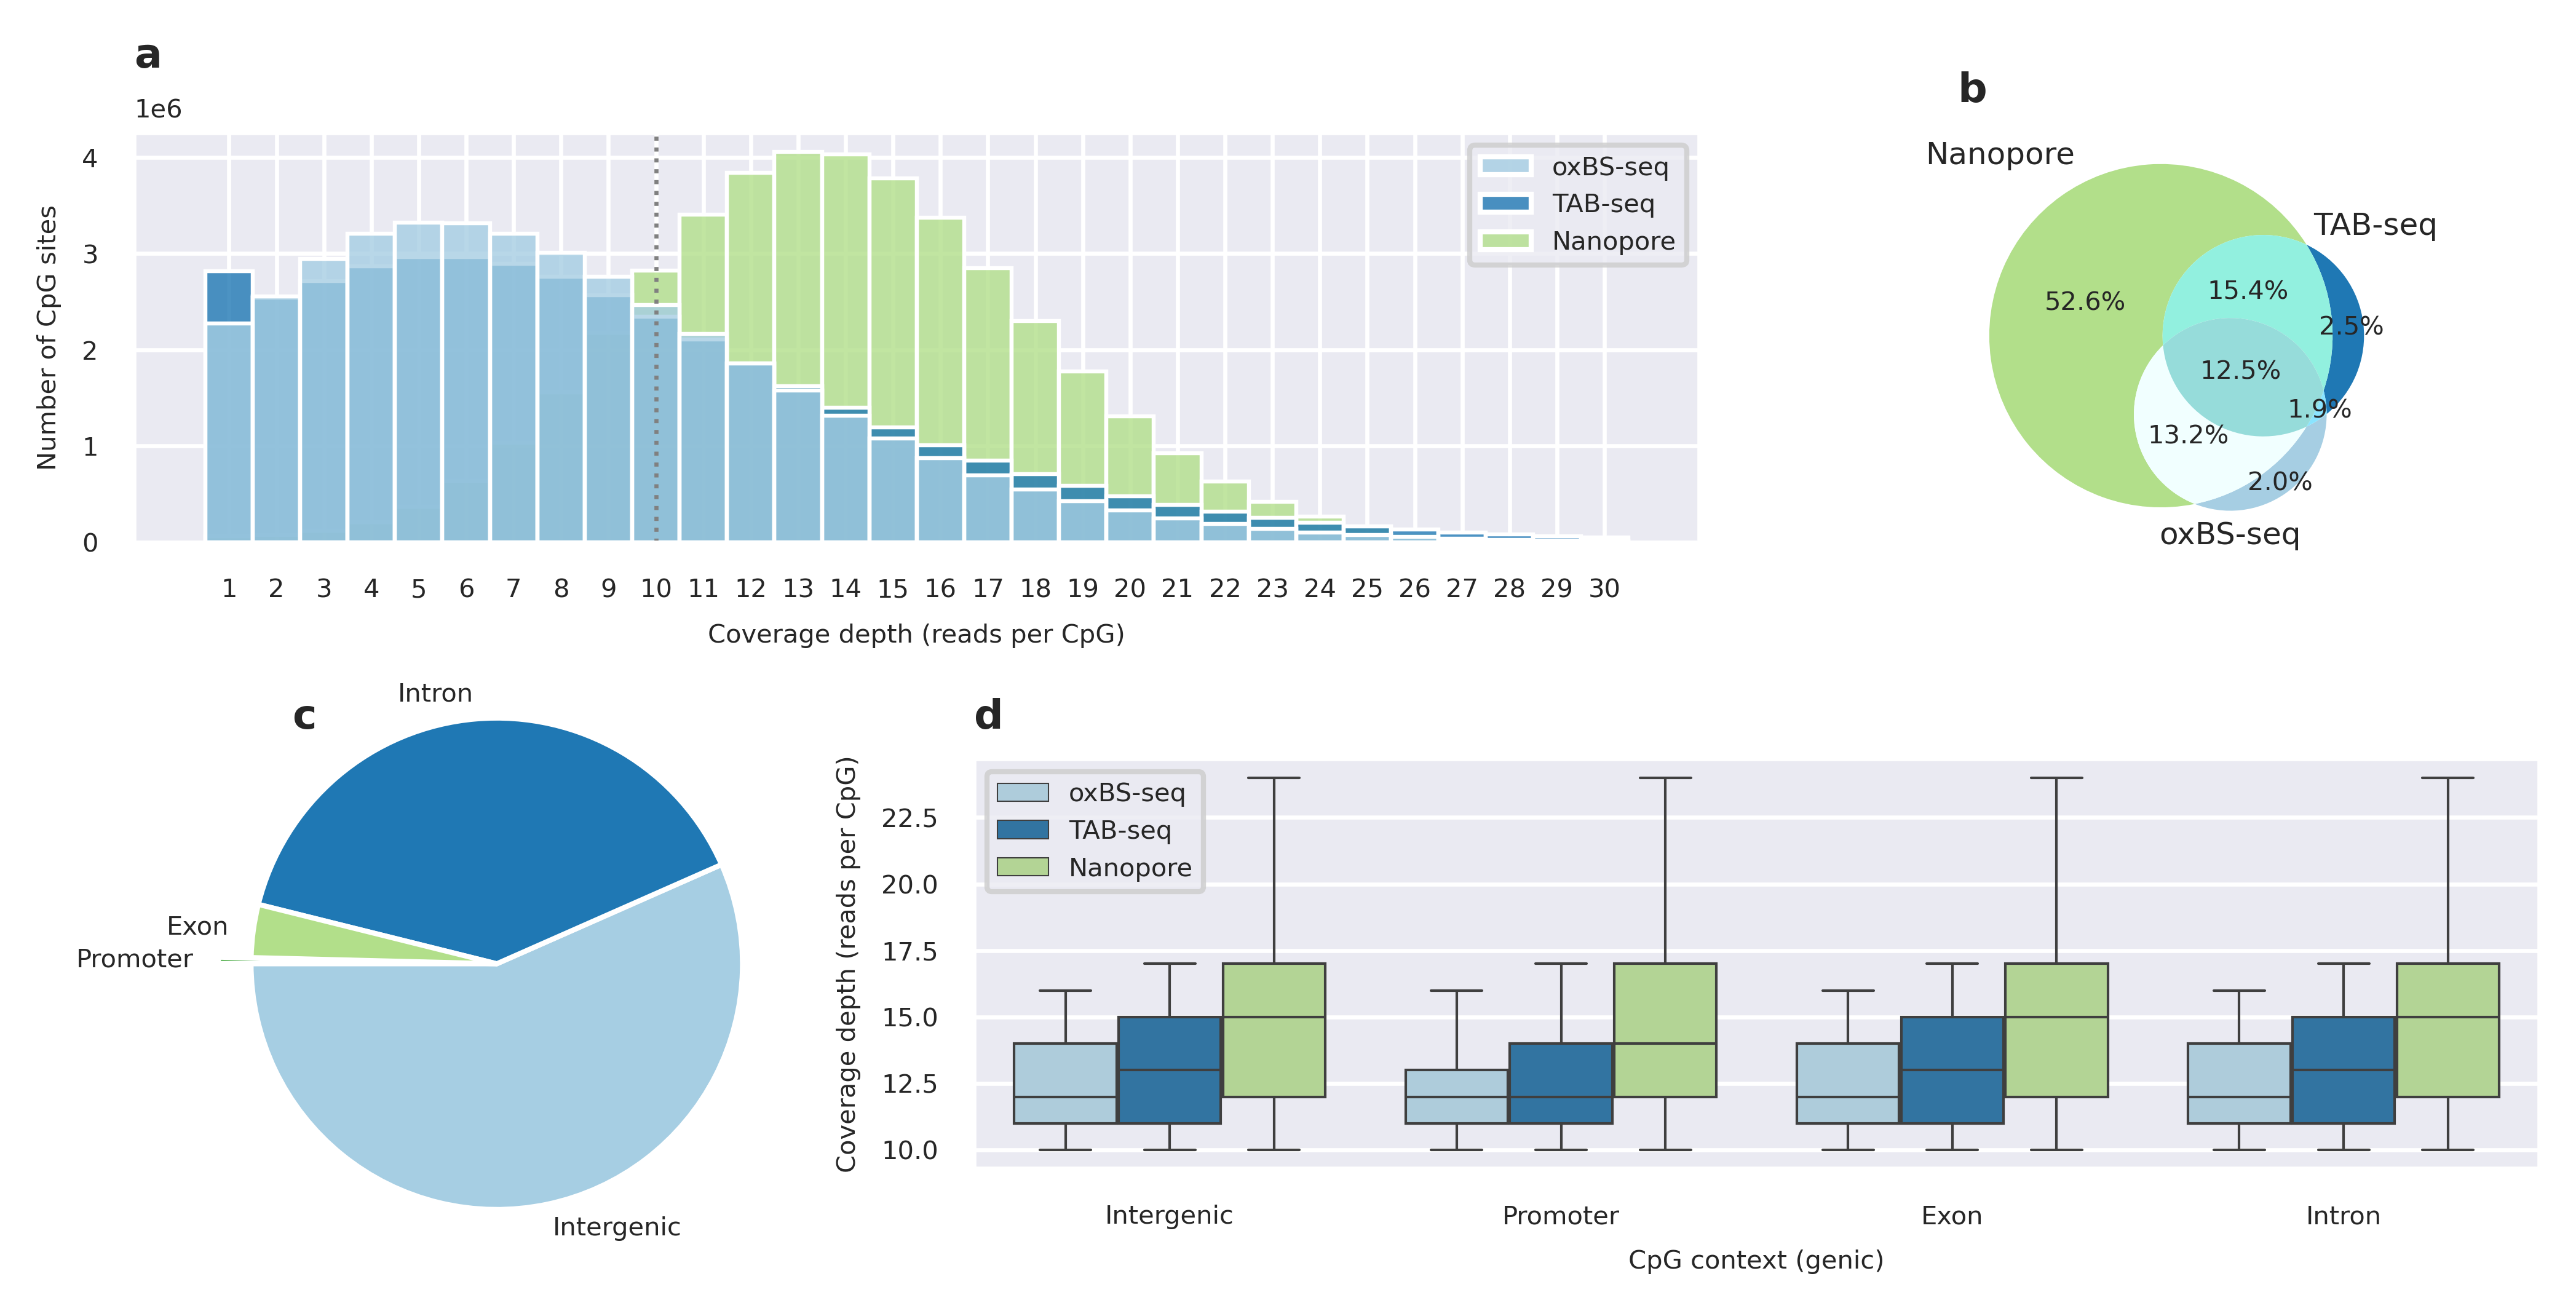

In [92]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
mpl.rc('font', size=5)

plt.figure(figsize=(180/25.4, 89/25.4), dpi=600)

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 3), (0, 2))
ax3 = plt.subplot2grid((2, 3), (1, 0))
ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=2)

# Panel 1 #
sns.histplot(histogram_df, x="readCount", 
             stat="count", discrete=True, binwidth=1, binrange=(1, 30),
             hue="method", palette="Paired", hue_order=["oxBS-seq", "TAB-seq", "Nanopore"], 
             legend=True, alpha=0.8, ax=ax1)
ax1.axvline(10, ls=":", c="grey", lw=0.8, label="Minimum")
ax1.set_ylabel("Number of CpG sites")
ax1.set_xlabel("Coverage depth (reads per CpG)")
ax1.set_xticks(range(1, 31))
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")
sns.move_legend(ax1, "upper right", title=None)

# Panel 2 # 
venn3(subsets=(prom_excl, tab_excl, prom_tab, oxbs_excl, prom_oxbs, tab_oxbs, len(prom_tab_oxbs)), 
      set_labels=("Nanopore", "TAB-seq", "oxBS-seq"),
      subset_label_formatter=lambda x: f"{(x/total):1.1%}",
      set_colors=(sns.color_palette("Paired", 3)[2], sns.color_palette("Paired", 3)[1], sns.color_palette("Paired", 3)[0]),
      alpha=1,
      ax=ax2)
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

# Panel 3 # 
ax3.pie(pie_values, labels=pie_labels, explode=(0, 0, 0, 0.2), startangle=180, radius=1.5, colors=sns.color_palette("Paired", 4))
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

# Panel 4 #
sns.boxplot(readcount_features_df, x="feature_type", y="readCount", 
            hue="method", palette="Paired", hue_order=["oxBS-seq", "TAB-seq", "Nanopore"], 
            dodge=True, linewidth=0.5, showfliers=False, 
            ax=ax4)
ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")
ax4.set_xlabel("CpG context (genic)")
ax4.set_ylabel("Coverage depth (reads per CpG)")
ax4.legend(title=None)

plt.tight_layout()
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/coverage_and_depth.png", dpi=600)


# CpG level comparison

## Raw data processing

In [1]:
import common 
import pandas as pd

if not "prom_comp_data" in locals().keys(): 
    nanopore_threemod_prom = common.readModbam2bed("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed", 
                                                   10, apply_max_depth=True)

    oxbs_df = common.readBismarkZeroCov("/mnt/data1/doh28/data/CRR008808_oxBS/extraction_output/mapq_filter/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", 
                                "5mC", min_depth=10, apply_max_depth=True)

    tab_df = common.readBismarkZeroCov("/mnt/data1/doh28/data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov",
                                    "5hmC", min_depth=10, apply_max_depth=True)
    
    bis_all = tab_df.merge(oxbs_df, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_oxBS"])

    prom_comp_data = nanopore_threemod_prom.merge(bis_all, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Nanopore", "_Bisulphite"])

In [11]:
prom_comp_data.to_csv("./data_tables/prom_comp_data_10x_wDepthFilt.tsv", index=False)

In [39]:
import common 
import pandas as pd

prom_comp_data = pd.read_csv("./data_tables/prom_comp_data_10x.tsv")

In [8]:
len(prom_comp_data.query("percentMeth_5hmC_Bisulphite == 0"))/len(prom_comp_data)

0.42033532544453694

In [2]:
oxbs_df = common.readBismarkZeroCov("/mnt/data1/doh28/data/CRR008808_oxBS/extraction_output/mapq_filter/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", 
                                "5mC", min_depth=10, apply_max_depth=True, incl_raw_counts=True)

In [2]:
nanopore_threemod_prom = common.readModbam2bed("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed", 10, apply_max_depth=True, incl_raw_counts=True)

In [8]:
nanopore_threemod_prom["N_mC"].sum()/nanopore_threemod_prom["readCount"].sum()

0.6914357487666568

In [4]:
oxbs_df["N_mod"].sum()/oxbs_df["readCount"].sum()

0.7491147618470776

## Similarities

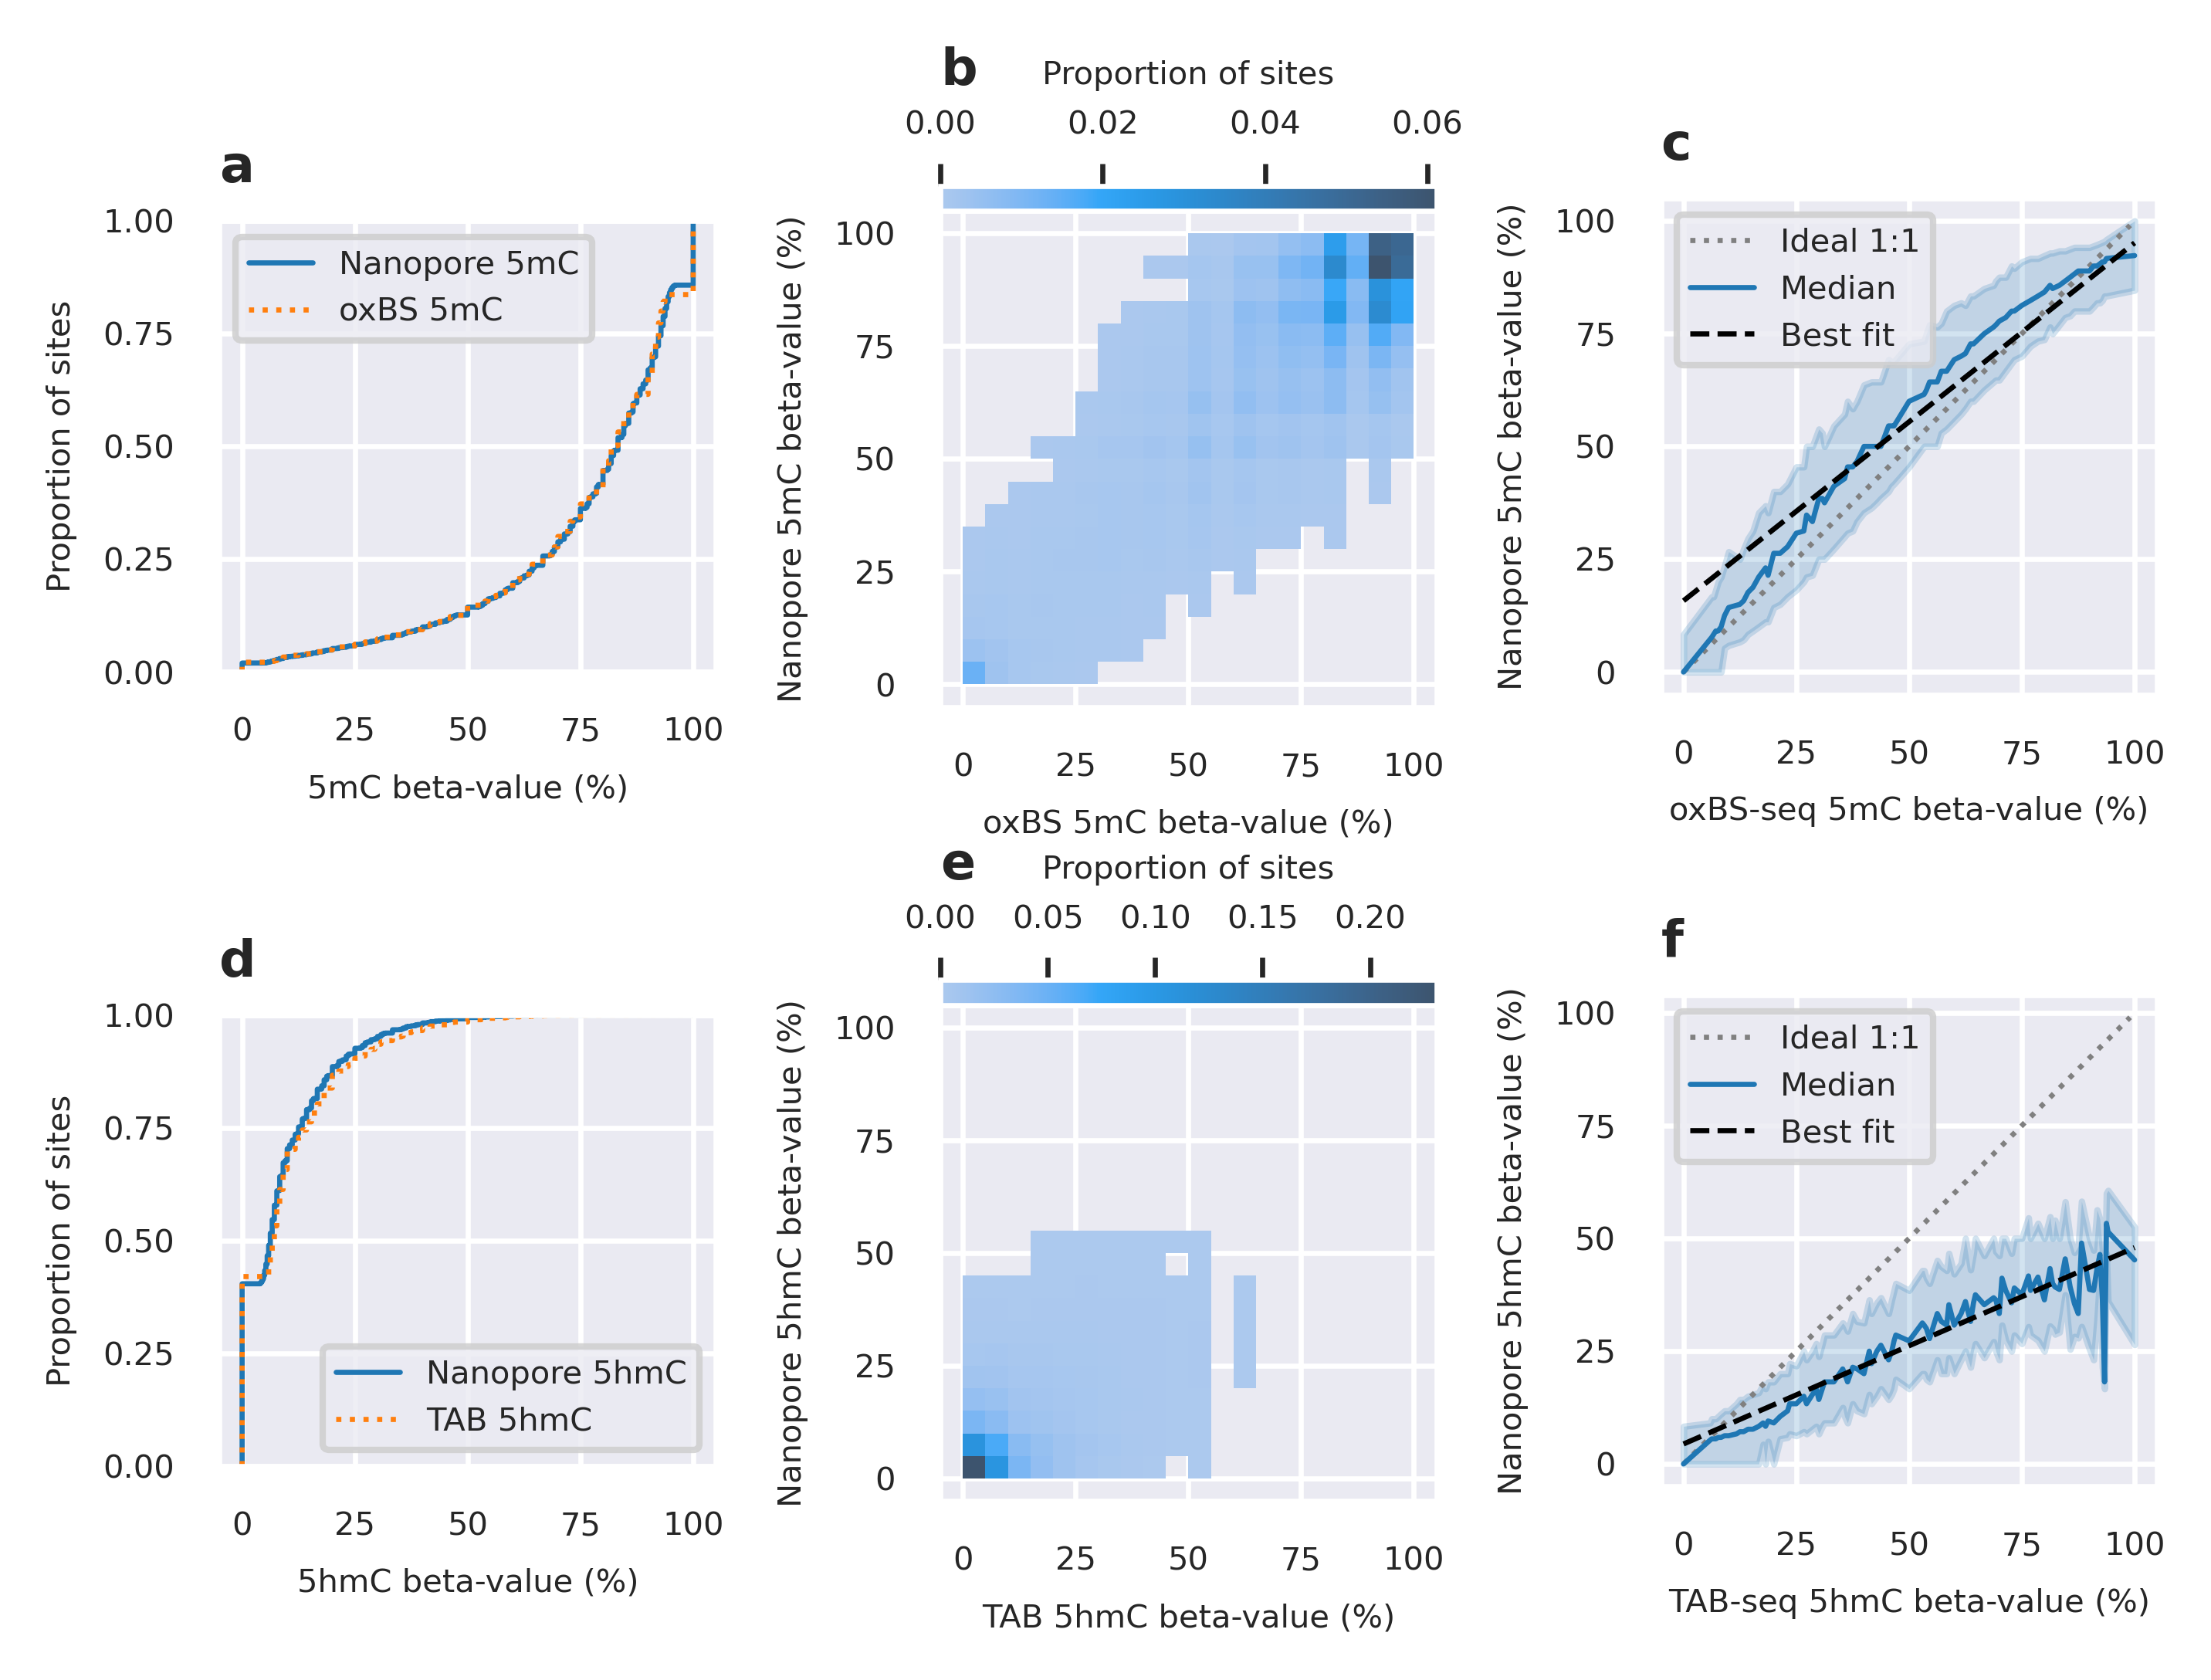

In [118]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.preprocessing import Binarizer
from sklearn import metrics

plt.figure(figsize=(120/25.4, 89/25.4), dpi=600)

sns.set_style("darkgrid")
mpl.rc('font', size=5)

ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))
ax6 = plt.subplot2grid((2, 3), (1, 2))

comparison = [["percentMeth_5mC_Nanopore", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Nanopore", "percentMeth_5hmC_Bisulphite"]]
legends = [["Nanopore 5mC", "oxBS 5mC"], ["Nanopore 5hmC", "TAB 5hmC"]]

# Panels 1 and 4 # 

for index, ax in enumerate([ax1, ax4]):
    sns.ecdfplot(prom_comp_data.melt(
            id_vars=["chromosome", "chromStart", "chromEnd"], 
            value_vars=comparison[index], var_name="method", value_name="percentMeth").query(f"method == '{comparison[index][0]}'"),
        x="percentMeth", ls="-", lw=0.8, label=legends[index][0], color=sns.color_palette()[0], ax=ax)
    
    sns.ecdfplot(prom_comp_data.melt(
            id_vars=["chromosome", "chromStart", "chromEnd"], 
            value_vars=comparison[index], var_name="method", value_name="percentMeth").query(f"method == '{comparison[index][1]}'"),
        x="percentMeth", ls=":", lw=0.8, label=legends[index][1], color=sns.color_palette()[1], ax=ax)

    ax.set_aspect(100)
    ax.set_xticks(np.arange(0, 125, 25))
    ax.set_yticks(np.arange(0, 1.25, 0.25))
    ax.set_ylabel("Proportion of sites")

ax1.set_xlabel("5mC beta-value (%)")
ax1.legend(labels=legends[0], title=None, loc="upper left")
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

ax4.set_xlabel("5hmC beta-value (%)")
ax4.legend(labels=legends[1], title=None, loc="lower right")
ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")

# Panels 2 and 5 # 

for index, ax in enumerate([ax2, ax5]):
    div = make_axes_locatable(ax)
    cax = div.append_axes("top", size="5%", pad=0)
    sns.histplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], 
                 stat="proportion", pthresh=0.01, binwidth=5, cbar=True, 
                 cbar_kws={"label" : "Proportion of sites",
                           "pad" : 0,
                           "orientation" : "horizontal",
                           "location" : "top"}, 
                 ax=ax, cbar_ax=cax)
    ax.set_aspect("equal")
    # ax.xaxis.tick_top()
    ax.set_yticks(np.arange(0, 125, 25))
    ax.set_xticks(np.arange(0, 125, 25))

ax2.set_xlabel("oxBS 5mC beta-value (%)")
ax2.set_ylabel("Nanopore 5mC beta-value (%)")
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold", y=1.15, pad=8)

ax5.set_xlabel("TAB 5hmC beta-value (%)")
ax5.set_ylabel("Nanopore 5hmC beta-value (%)")
ax5.set_title("e", loc="left", fontsize=8, fontweight="bold", y=1.15, pad=8)

# Panels 3 and 6 # 

for index, ax in enumerate([ax3, ax6]):
    ax.plot(np.arange(0, 100, 1), np.arange(0, 100, 1), c="grey", ls=":", lw=0.8, label="Ideal 1:1")
    sns.lineplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], 
                 label="Median", estimator='median', errorbar=("pi", 50), lw=0.8, ax=ax)
    sns.regplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], 
                 ci=None, color="black", line_kws={
                    "ls" : "--",
                    "lw" : 0.8
                    }, label="Linear model", scatter=False, ax=ax)
    ax.set_aspect("equal")
    ax.set_xticks(np.arange(0, 125, 25))
    ax.set_yticks(np.arange(0, 125, 25))
    ax.legend()

ax3.set_xlabel("oxBS-seq 5mC beta-value (%)")
ax3.set_ylabel("Nanopore 5mC beta-value (%)")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

ax6.set_xlabel("TAB-seq 5hmC beta-value (%)")
ax6.set_ylabel("Nanopore 5hmC beta-value (%)")
ax6.set_title("f", loc="left", fontsize=8, fontweight="bold")

# Plot figure # 

plt.gcf().set_size_inches(120/25.4, 89/25.4)
plt.tight_layout()
# plt.subplots_adjust(wspace=1.1, hspace=-0.1)
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/CpG_level_sim.png", dpi=600)

In [ ]:
div5 = make_axes_locatable(ax5)
cax5 = div5.append_axes("top", size="5%", pad=0)

true, pred = prom_comp_data["percentMeth_5hmC_Bisulphite"].to_numpy().reshape((-1, 1)), prom_comp_data["percentMeth_5hmC_Nanopore"].to_numpy().reshape((-1, 1))

binarizer = Binarizer(threshold=0)
true_b, pred_b = binarizer.fit_transform(true), binarizer.fit_transform(pred)
cm = metrics.ConfusionMatrixDisplay.from_predictions(
    true_b, pred_b, 
    display_labels=["Absent", "Present"], 
    normalize="all", 
    colorbar=False, cmap="Blues", 
    im_kw={"origin" : "lower"}, 
    values_format=".2f",
    ax=ax5)

plt.colorbar(cm.im_, cax5, label="Proportion of sites", orientation="horizontal", location="top", ticks=[0.25, 0.35])
ax5.grid(False)
ax5.set_xlabel("Nanopore 5hmC")
# ax5.xaxis.set_label_position("top")
# ax5.xaxis.tick_top()
ax5.set_ylabel("TAB 5hmC")

In [19]:
from sklearn.linear_model import LinearRegression
from scipy import stats

model = LinearRegression()

comparison = [["percentMeth_5mC_Nanopore", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Nanopore", "percentMeth_5hmC_Bisulphite"]]

for comp in comparison:
    x = prom_comp_data[comp[1]].to_numpy().reshape(-1, 1)
    y = prom_comp_data[comp[0]].to_numpy().reshape(-1, 1)

    model.fit(x, y)
    print(f"Pearson: {stats.pearsonr(prom_comp_data[comp[0]], prom_comp_data[comp[1]])}")
    print(f"Model for {comp[0]} ~ {comp[1]}: {round(float(model.intercept_), 3)} + {round(float(model.coef_), 3)}X; R\N{SUPERSCRIPT TWO}={round(float(model.score(x, y)), 3)}")

Pearson: PearsonRResult(statistic=0.7991247687687296, pvalue=0.0)
Model for percentMeth_5mC_Nanopore ~ percentMeth_5mC_Bisulphite: 15.79 + 0.793X; R²=0.639
Pearson: PearsonRResult(statistic=0.4910741636263641, pvalue=0.0)
Model for percentMeth_5hmC_Nanopore ~ percentMeth_5hmC_Bisulphite: 4.422 + 0.435X; R²=0.241


## Differences

In [3]:
import pandas as pd
prom_comp_data = pd.read_csv("./data_tables/prom_comp_data_10x.tsv")

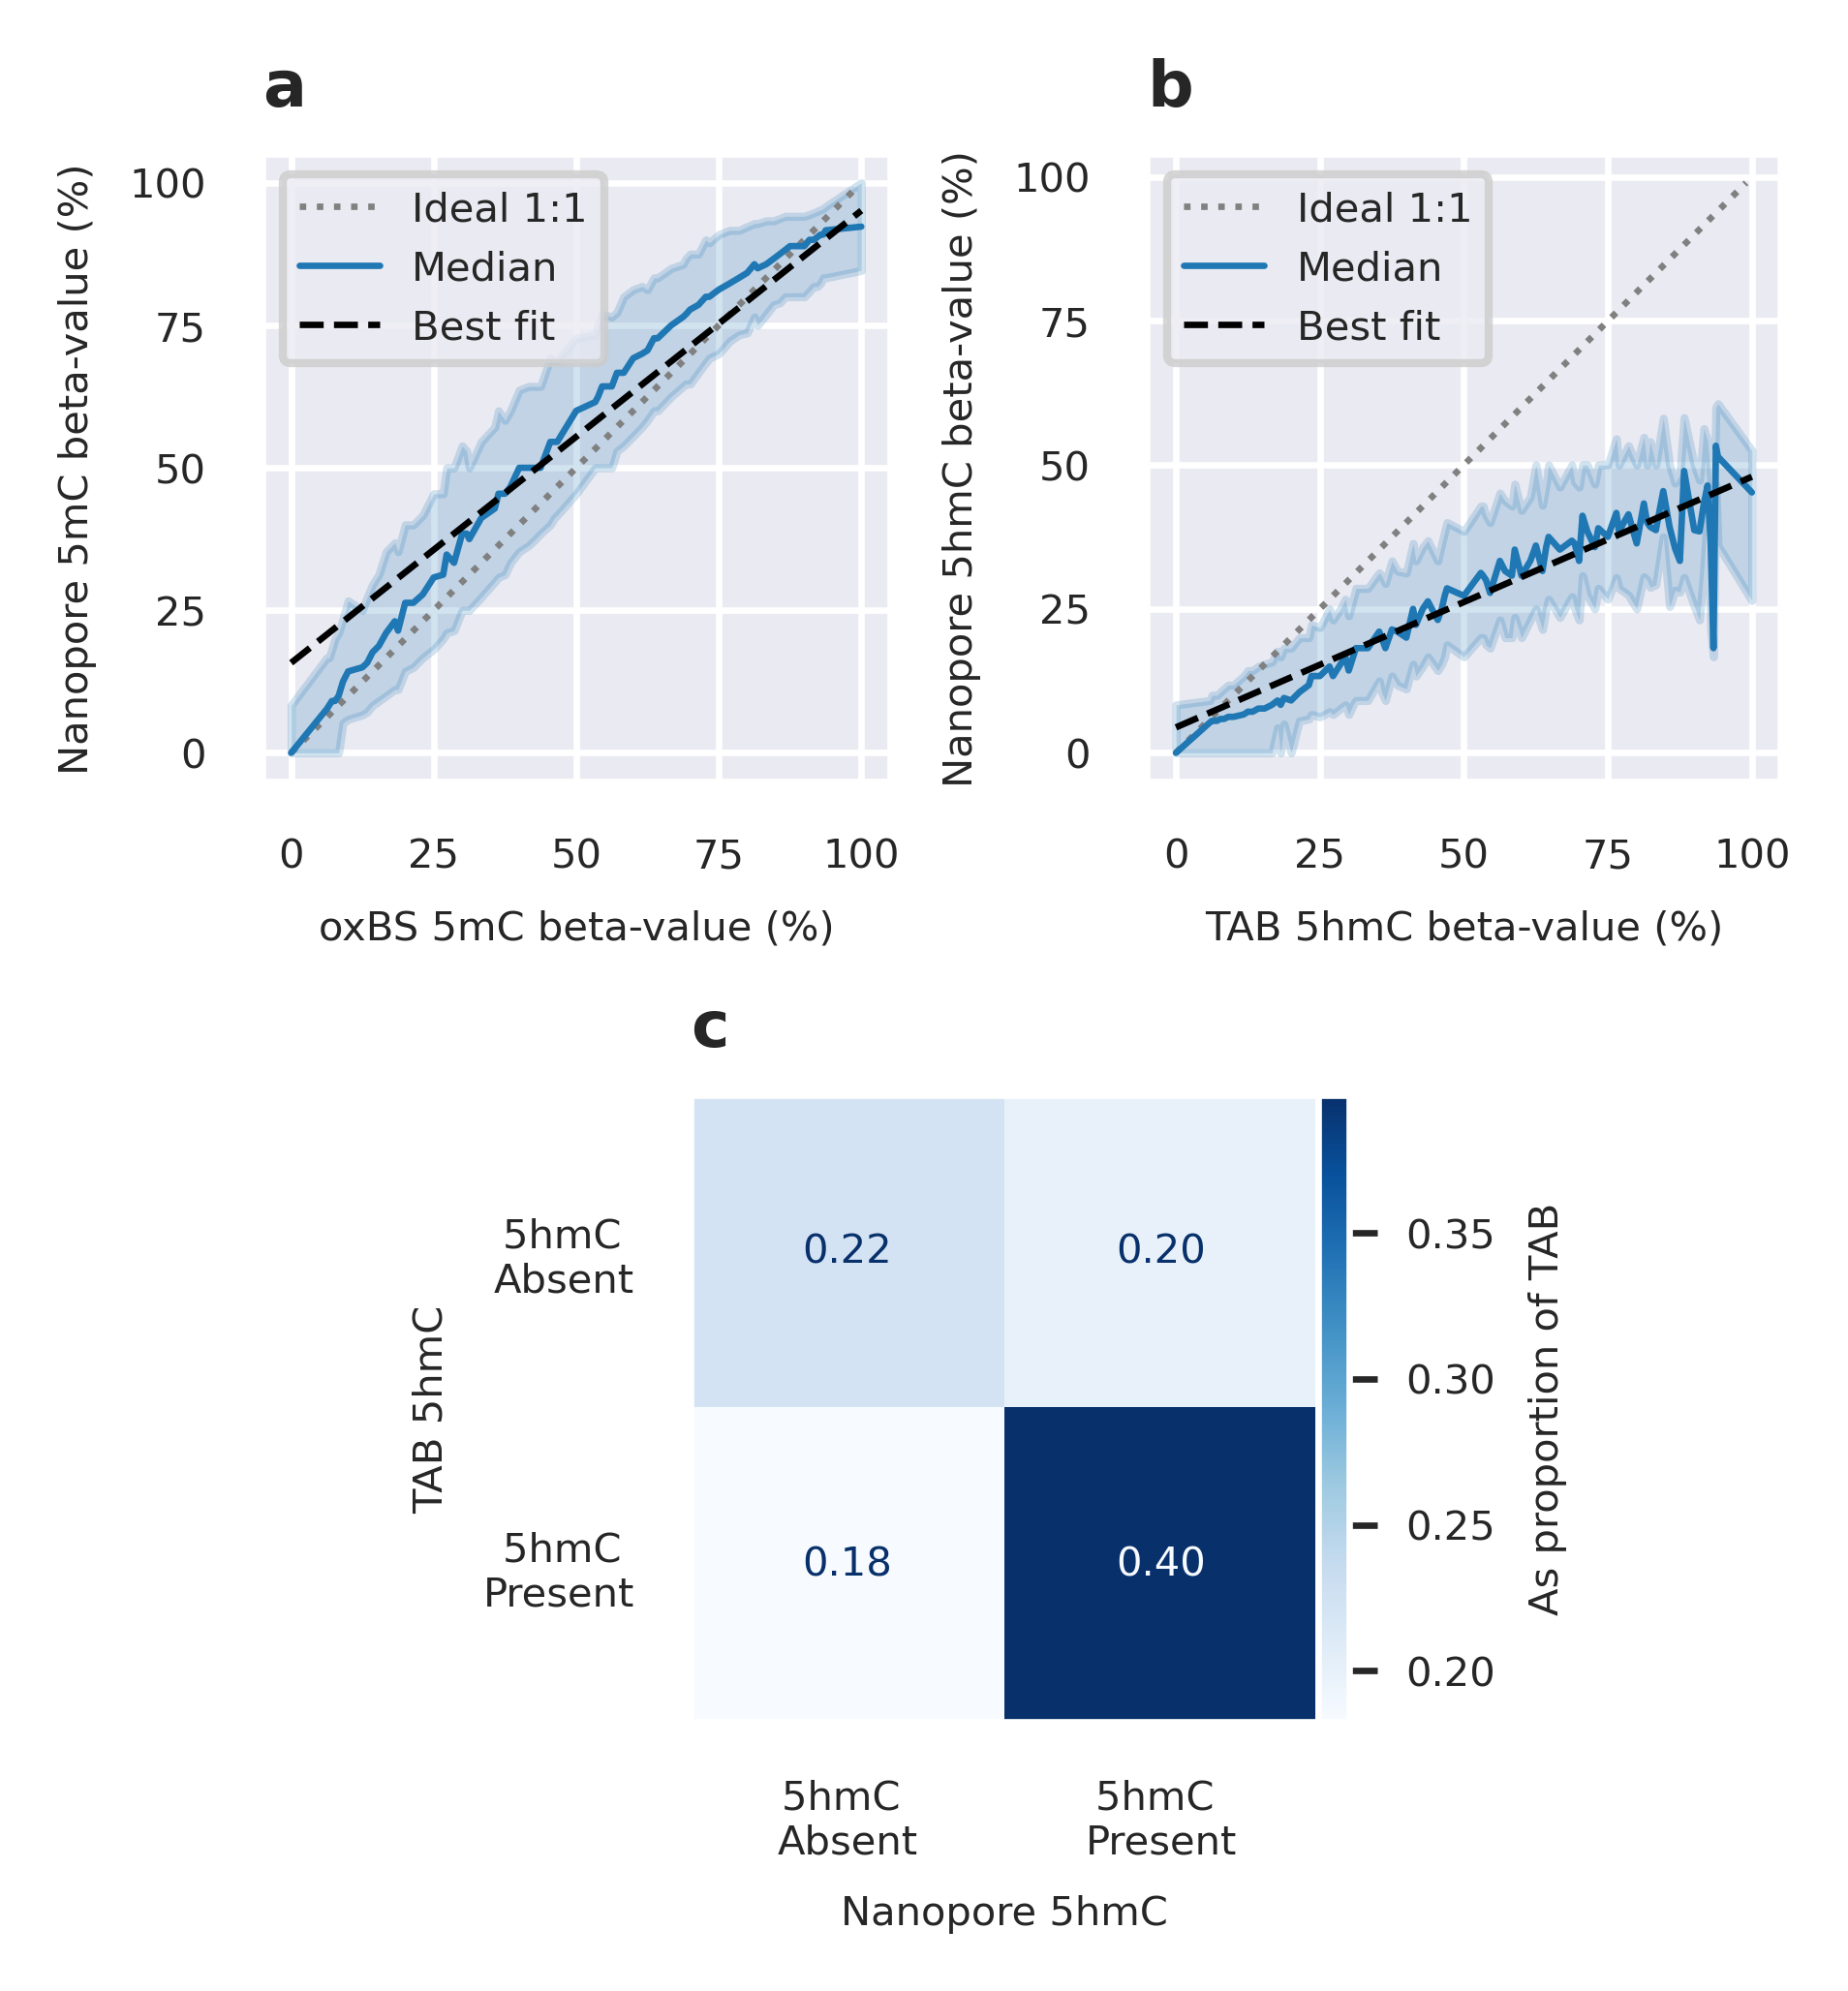

In [4]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import Binarizer
from sklearn import metrics
from cycler import cycler

plt.figure(figsize=(89/25.4, 89/25.4), dpi=600)

sns.set_style("darkgrid")
mpl.rc('font', size=5)

ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 4), (0, 2), colspan=2)
ax3 = plt.subplot2grid((2, 4), (1, 1), colspan=2)

##### Row 1 #####
# Panel 1 and 2 # 

comparison = [["percentMeth_5mC_Nanopore", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Nanopore", "percentMeth_5hmC_Bisulphite"]]

for index, ax in enumerate([ax1, ax2]):
    ax.plot(np.arange(0, 100, 1), np.arange(0, 100, 1), c="grey", ls=":", lw=0.8, label="Ideal 1:1")
    sns.lineplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], 
                 label="Median", estimator='median', errorbar=("pi", 50), lw=0.8, ax=ax)
    sns.regplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], 
                 ci=None, color="black", line_kws={
                    "ls" : "--",
                    "lw" : 0.8
                    }, label="Best fit", scatter=False, ax=ax)
    ax.set_aspect("equal")
    ax.set_xticks(np.arange(0, 125, 25))
    ax.set_yticks(np.arange(0, 125, 25))
    ax.legend()

ax1.set_xlabel("oxBS 5mC beta-value (%)")
ax1.set_ylabel("Nanopore 5mC beta-value (%)")
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

ax2.set_xlabel("TAB 5hmC beta-value (%)")
ax2.set_ylabel("Nanopore 5hmC beta-value (%)")
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

##### Row 2 #####
# Panel 3 # 

div = make_axes_locatable(ax3)
cax = div.append_axes("right", size="5%", pad=0)

true, pred = prom_comp_data["percentMeth_5hmC_Bisulphite"].to_numpy().reshape((-1, 1)), prom_comp_data["percentMeth_5hmC_Nanopore"].to_numpy().reshape((-1, 1))

binarizer = Binarizer(threshold=0)
true_b, pred_b = binarizer.fit_transform(true), binarizer.fit_transform(pred)
cm = metrics.ConfusionMatrixDisplay.from_predictions(
    true_b, pred_b, 
    display_labels=["5hmC \nAbsent", "5hmC \nPresent"], 
    normalize="all", 
    colorbar=False, cmap="Blues", 
    im_kw={"origin" : "lower"}, 
    values_format=".2f",
    ax=ax3)

plt.colorbar(cm.im_, cax, label="As proportion of TAB")
ax3.grid(False)
ax3.set_xlabel("Nanopore 5hmC")
ax3.set_ylabel("TAB 5hmC")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

plt.gcf().set_size_inches(89/25.4, 89/25.4)
plt.subplots_adjust(wspace=0.8, hspace=0.5)
# plt.tight_layout()
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/CpG_level_dif.png", dpi=600)

# Macro-level 5hmC comparison

In [14]:
import pandas as pd
from MultisiteTools import *
from common import *

nano_path = "/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed"
tab_path = "/mnt/data1/doh28/data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov"

prom_tab_comp = makeCpGRange(nano_path, tab_path)

Changing colnames to be PyRanges compatible...
Done
Changing colnames to be PyRanges compatible...
Done


Deprecating

In [11]:
@asPyRangesDecorator
def readAsPr(path):
    return pd.read_csv(path)

path = "./data_tables/prom_comp_data_10x_wDepthFilt.tsv"
prom_comp_pr = CpGRange(readAsPr(path).as_df())


Changing colnames to be PyRanges compatible...
Done


In [2]:
def makeCpGRange(nanopore_path, tab_path):
    nanopore_pr = Modbam2Pr(nanopore_path)
    tab_pr = Bismark2Pr(tab_path, "5hmC")

    merged_df = nanopore_pr.join(tab_pr, False, suffix="_TAB").as_df()

    merged_df = merged_df.rename(columns={
        "percentMeth_5hmC" : "percentMeth_5hmC_Nanopore"
    })
    return CpGRange(merged_df)
    

In [15]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    all_features = prom_tab_comp.group_by_annotation("features", "./feature_references/genic/").enrichment_over_mean(include_zeros=True).df
    all_cgi = prom_tab_comp.group_by_annotation("CGI", "./feature_references/cgi/").enrichment_over_mean(include_zeros=True).df
    all_genes = prom_tab_comp.group_by_annotation("genes", "./feature_references/genes/EncodeGencodeBasicVM32_Genes.bed").enrichment_over_mean(include_zeros=True).df

features_genes_cgi = pd.concat([all_features, all_cgi, all_genes])

In [18]:
features_genes_cgi = features_genes_cgi.query("log2enrichment_5hmC_TAB > -inf & log2enrichment_5hmC_Nanopore > -inf")
all_hists = features_genes_cgi.replace(["3UTR", "5UTR", "Genes", "CGI"], ["Exon", "Exon", "Gene body", "CpG island"])
all_hists = all_hists.query("feature_type != 'Intergenic' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf'")

In [24]:
def replaceDecorator(func):
    def renameWrapper(*args, **kwargs):
        return func(*args, **kwargs).replace(["Bisulphite"], ["TAB"], errors="ignore")
    return renameWrapper

def annotationPivot(df):
    pivoted_df = pd.wide_to_long(df, 
        stubnames=["percentMeth_5mC", "log2enrichment_5mC", "percentMeth_5hmC", "log2enrichment_5hmC"], 
        i=["Name", "feature_type", "Start", "End"], 
        j="method", sep="_", suffix="\D+")
    return pivoted_df.reset_index()

@replaceDecorator
def replacePivoter(df):
    return annotationPivot(df)

In [25]:
genic_df = features_genes_cgi.query("feature_type != 'Intergenic' & feature_type != 'Genes' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf' & feature_type != 'CGI'")
cgi_df = features_genes_cgi.query("feature_type == 'CGI' | feature_type == 'Shelf' | feature_type == 'Shore'").replace("CGI", "Island")

genic_barplot_df, cgi_barplot_df = map(annotationPivot, [genic_df, cgi_df])

## Figure

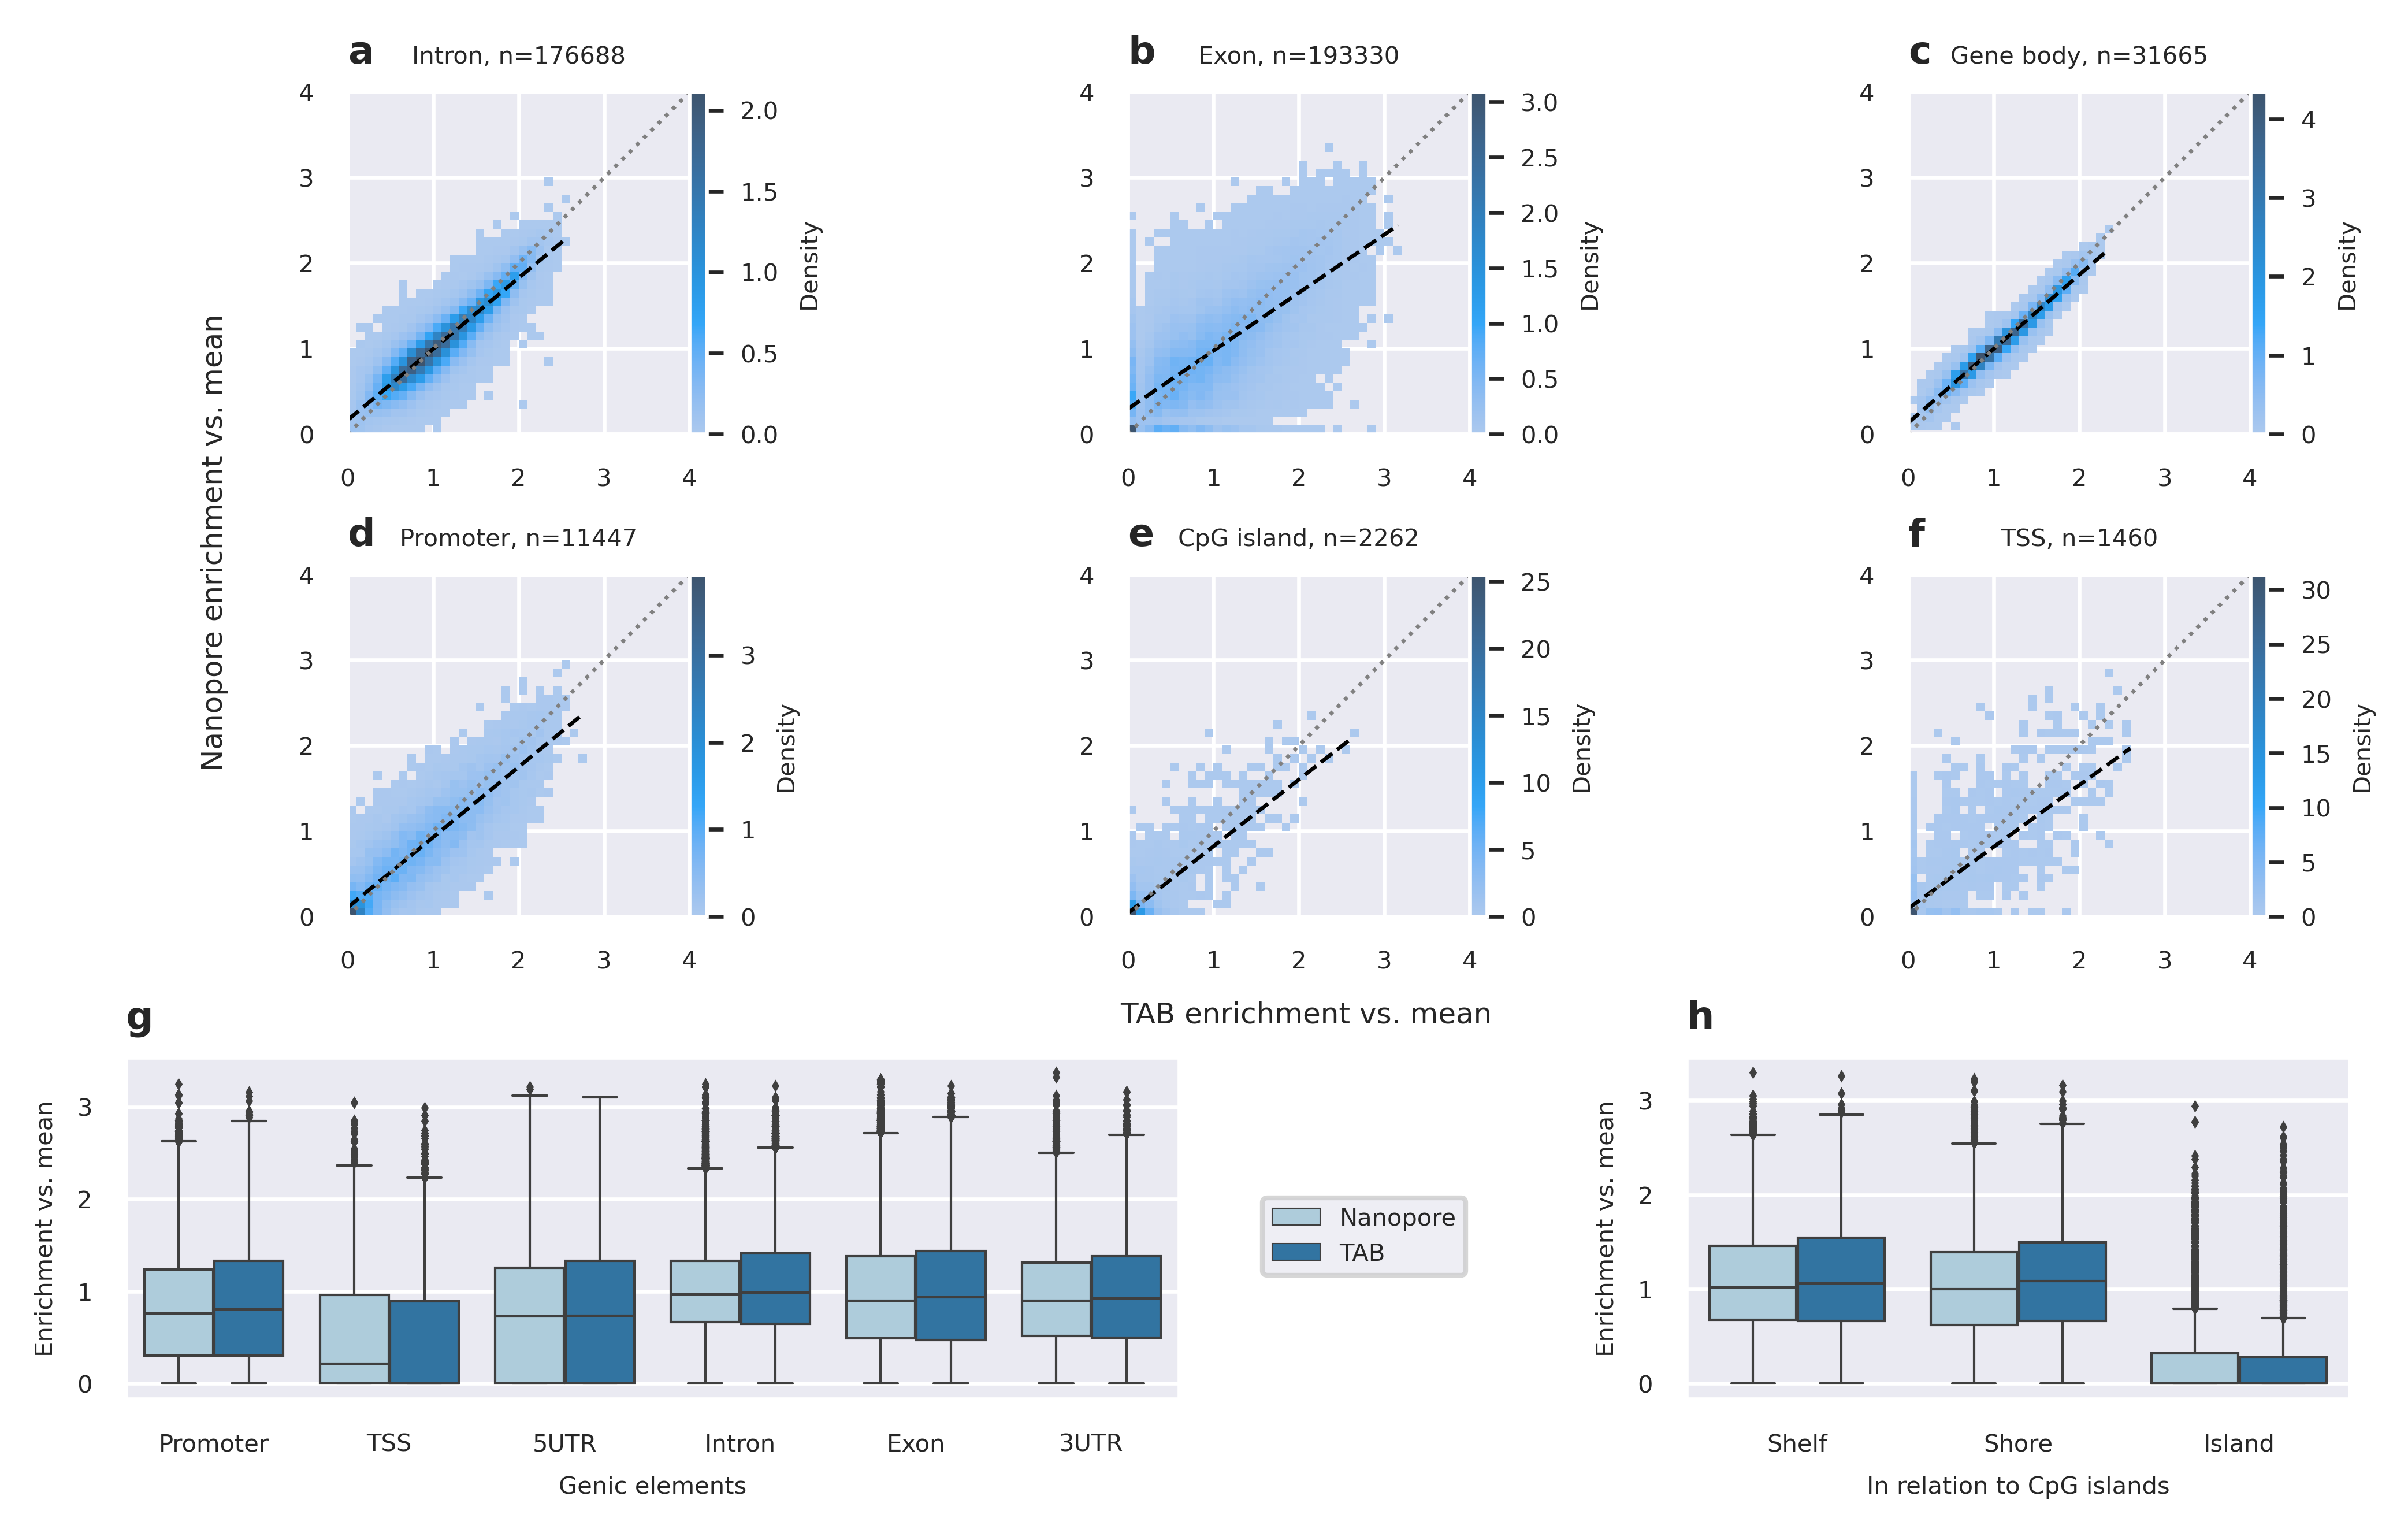

In [27]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("darkgrid")

fig = plt.figure(figsize=(180/25.4, 115/25.4), dpi=600)
mpl.rc('font', size=5)

rows = 6

ax1 = plt.subplot2grid((rows, 6), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((rows, 6), (0, 2), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((rows, 6), (0, 4), colspan=2, rowspan=2)
ax4 = plt.subplot2grid((rows, 6), (2, 0), colspan=2, rowspan=2)
ax5 = plt.subplot2grid((rows, 6), (2, 2), colspan=2, rowspan=2)
ax6 = plt.subplot2grid((rows, 6), (2, 4), colspan=2, rowspan=2)
ax7 = plt.subplot2grid((rows, 6), (4, 0), colspan=3, rowspan=2)
ax8 = plt.subplot2grid((rows, 6), (4, 4), colspan=2, rowspan=2)

hist_axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ax_titles = ["a", "b", "c", "d", "e", "f"]
feature_order = ["Intron", "Exon", "Gene body", "Promoter", "CpG island", "TSS"]

for i, feature_type in enumerate(feature_order):
    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")

    sns.histplot(hist_df, x="log2enrichment_5hmC_TAB", y="log2enrichment_5hmC_Nanopore", 
                 binwidth=0.1, cbar=True, stat="density", cbar_kws={"label" : "Density", "pad" : 0},
                 ax=hist_axes[i])
    
    sns.regplot(hist_df, x="log2enrichment_5hmC_TAB", y="log2enrichment_5hmC_Nanopore", 
                 scatter=False, ci=None, color="black", 
                 line_kws={"ls" : "--", "lw" : 0.8},
                 x_ci=None, robust=True,
                 ax=hist_axes[i])

    hist_axes[i].set_aspect("equal")
    hist_axes[i].set_ylabel(None)
    hist_axes[i].set_xlabel(None)
    # hist_axes[i].set_ylabel("Nanopore enrichment\nvs. mean")
    # hist_axes[i].set_xlabel("TAB-seq enrichment vs. mean")
    hist_axes[i].set_ylim((0, 4))
    hist_axes[i].set_xlim((0, 4))

    hist_axes[i].set_xticks(ticks=range(0, 5, 1))

    # ax.axhline(0, ls=":", lw=0.8, c="grey")
    # ax.axvline(0, ls=":", lw=0.8, c="grey")

    hist_axes[i].plot((0, 5), (0, 5), ls=":", lw=0.8, c="grey")
    hist_axes[i].set_title(f"{feature_order[i]}, n={len(hist_df)}", loc="center", fontsize=5)
    hist_axes[i].set_title(f"{ax_titles[i]}", loc="left", fontsize=8, fontweight="bold")

fig.supylabel("Nanopore enrichment vs. mean", y=0.66, x=0.1)
fig.supxlabel("TAB enrichment vs. mean", y=0.35, x=0.55)

genic_barplot_df["feature_type"] = pd.Categorical(genic_barplot_df["feature_type"], 
                                                  ["Promoter", "TSS", "5UTR", "Intron", "Exon", "3UTR"])
cgi_barplot_df["feature_type"] = pd.Categorical(cgi_barplot_df["feature_type"],
                                                ["Shelf", "Shore", "Island"])
barplots = [genic_barplot_df, cgi_barplot_df]

for i, ax in enumerate([ax7, ax8]):
    df = barplots[i]
    sns.boxplot(df, x="feature_type", y="log2enrichment_5hmC", 
                hue="method", palette="Paired", dodge=True, linewidth=0.5,
                showfliers=True, fliersize=0.5,
                ax=ax)
    ax.set_title(f"{['g', 'h'][i]}", loc="left", fontsize=8, fontweight="bold")
    ax.set_xlabel(f"{['Genic elements', 'In relation to CpG islands'][i]}")
    ax.set_ylabel("Enrichment vs. mean")
    ax.get_legend().set_visible(False)

barplot_handles, barplot_labels = ax7.get_legend_handles_labels()

fig.legend(barplot_handles, barplot_labels, bbox_to_anchor=(0.62, 0.25))

fig.tight_layout()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/macro_level_analysis_including_zeros.png", dpi=600)

## Stats

In [29]:
from sklearn.linear_model import LinearRegression
from scipy import stats

model = LinearRegression()

feature_order = ["Intron", "Exon", "Gene body", "Promoter", "TSS", "CpG island"]

for i, feature_type in enumerate(feature_order):
    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")
    
    new_median = hist_df["CpG_count"].min()
    x, y = hist_df["log2enrichment_5hmC_TAB"], hist_df["log2enrichment_5hmC_Nanopore"]

    x_np, y_np = x.to_numpy().reshape(-1, 1), y.to_numpy().reshape(-1, 1)

    def statistic(x, y, axis):
        return np.mean(x, axis=axis) - np.mean(y, axis=axis)

    model.fit(x_np, y_np)

    print(f"{feature_type}: {new_median}, {len(hist_df)}")
    print(f"Pearson: {stats.pearsonr(x, y)}; Spearman: {stats.spearmanr(x, y)}")
    print(f"Y = {model.coef_}x + {model.intercept_}, {model.score(x_np, y_np)}")
    if len(hist_df) <= 2000:
        print(f"Permutation: {stats.permutation_test([x, y], statistic).pvalue}")

Intron: 10, 176688
Pearson: PearsonRResult(statistic=0.9007302639768036, pvalue=0.0); Spearman: SignificanceResult(statistic=0.8886267533427809, pvalue=0.0)
Y = [[0.81937931]]x + [0.17386116], 0.8113150084437224
Exon: 2, 193330
Pearson: PearsonRResult(statistic=0.6866009245792777, pvalue=0.0); Spearman: SignificanceResult(statistic=0.6599007152931167, pvalue=0.0)
Y = [[0.65557045]]x + [0.31947521], 0.4714208296331225
Gene body: 56, 31665
Pearson: PearsonRResult(statistic=0.9755059957808719, pvalue=0.0); Spearman: SignificanceResult(statistic=0.9745061481602973, pvalue=0.0)
Y = [[0.86406545]]x + [0.13182933], 0.9516119478044307
Promoter: 5, 11447
Pearson: PearsonRResult(statistic=0.8590281859969925, pvalue=0.0); Spearman: SignificanceResult(statistic=0.8473056171601506, pvalue=0.0)
Y = [[0.80883173]]x + [0.12173052], 0.7379294243372836
TSS: 2, 1460
Pearson: PearsonRResult(statistic=0.7151878404137295, pvalue=4.484051005310945e-229); Spearman: SignificanceResult(statistic=0.6247174370263

In [33]:
for feature_type in list(all_hists["feature_type"].unique()):
    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.25)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median}")
    print(feature_type, cpg_count_median, len(hist_df))


Promoter 2.0 7178
TSS 1.0 356
Exon 1.0 101739
Intron 3.0 198477
Gene body 9.0 41103
CGI 3.5 167


In [ ]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

plt.figure(figsize=(180/25.4, 115/25.4), dpi=600)
sns.set_style("darkgrid")
mpl.rc('font', size=5)


all_features_df = all_features_df.replace("Bisulphite", "TAB")
all_cgi_df = all_cgi_df.replace("Bisulphite", "TAB")

# Panel 3 # 
sns.barplot(all_features_df.query("Name != 'Intergenic' & log2enrichment_5hmC != -inf"), x="feature_type", y="log2enrichment_5hmC", 
            hue="method", palette="Paired", errwidth=0.4, errorbar=("sd", 1), capsize=0.1, ax=ax3)
ax3.set_ylabel(f"Enrichment score")
ax3.tick_params("x", labelrotation=0, direction="out")
ax3.set_xlabel("Context (genic)")
ax3.legend(title=None, loc="upper right", bbox_to_anchor=(1.1, 1))
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

# Panel 4 #
sns.barplot(all_cgi_df.query("Name != 'Open sea' & log2enrichment_5hmC != -inf"), x="feature_type", y="log2enrichment_5hmC", 
            hue="method", palette="Paired", errwidth=0.4, errorbar=("sd", 1), capsize=0.1, ax=ax4)
ax4.set_ylabel(f"Enrichment score")
ax4.tick_params("x", labelrotation=0, direction="out")
ax4.set_xlabel("Context (CpG island)")
ax4.legend(title=None, loc="upper right")
ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")

plt.subplots_adjust(wspace=0.2, hspace=0.6)

# Panel 5 # 
div5 = make_axes_locatable(ax5)
cax5 = div5.append_axes("right", size="5%", pad=0)

sns.histplot(all_genes.query("CpG_count >= 10"), x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", 
             stat="proportion", cbar=True, cbar_ax=cax5, cbar_kws={"label" : "Proportion of genes"}, bins=50, ax=ax5)
sns.regplot(all_genes.query("CpG_count >= 10"), x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", 
            scatter=False, line_kws={"color" : "grey", 
                                     "ls" : ":", 
                                     "lw" : 0.8}, 
            label="Best fit", ax=ax5)
ax5.set_title("e", loc="left", fontsize=8, fontweight="bold")

# Panel 6 # 
div6 =  make_axes_locatable(ax6)
cax6 = div6.append_axes("right", size="5%", pad=0)

sns.histplot(all_features.query("CpG_count >=2 & feature_type == 'Promoter'"), 
             x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", 
             stat="proportion", cbar=True, cbar_ax=cax6, cbar_kws={"label" : "Proportion of promoters"}, bins=50, ax=ax6)
sns.regplot(all_features.query("CpG_count >=2 & feature_type == 'Promoter'"), 
            x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", scatter=False, line_kws={"color" : "grey", 
                                                                                                           "ls" : ":", 
                                                                                                           "lw" : 0.8}, 
            label="Best fit", ax=ax6)
ax6.set_title("f", loc="left", fontsize=8, fontweight="bold")

for ax in [ax5, ax6]:
    ax.set_xlabel("TAB enrichment score")
    ax.set_ylabel("Nanopore enrichment score")
    ax.set_aspect("equal")
    ax.legend(loc="upper left")

plt.tight_layout()
plt.gcf().set_size_inches(180/25.4, 115/25.4)
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/macro_level.png", dpi=600)

In [24]:
all_features.query("feature_type == 'Promoter'")["CpG_count"].quantile(0.234)

2.0

In [14]:
all_genes["CpG_count"].quantile(0.25)

10.0

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

comparison =[all_genes.query("CpG_count >= 10"), all_features.query("CpG_count >= 2 & feature_type == 'Promoter'")]

for comp in comparison:
    x = comp["log2enrichment_5hmC_Bisulphite"].to_numpy().reshape(-1, 1)
    y = comp["log2enrichment_5hmC_Nanopore"].to_numpy().reshape(-1, 1)

    model.fit(x, y)
    print(f"Model: {round(float(model.intercept_), 3)} + {round(float(model.coef_), 3)}X; R\N{SUPERSCRIPT TWO}={round(float(model.score(x, y)), 3)}")

Model: 0.187 + 0.808X; R²=0.865
Model: 0.182 + 0.743X; R²=0.634


# Novelties in NGS 5hmC sequencing
Here I will show features that make NGS sequencing, in particular nanopore long reads, unique in the context of 5hmC sequencing - namely the ability to directly contextualise 5hmC in the differentially methylated regions of imprinted genes, and the sensitivity of the sequencer to low input 5hmC-enriched DNA. 

In [1]:
import pandas as pd
import ImprintPhasing
import ModBamTools 

read_path = "/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/alignments/prom_R10.4.1_E8.2_WGS_0.3.2_dmrs.bam"
dmr_path = "./feature_references/dmr/mm39_dmr_coordinatesEdited.bed"

dmr_regions = pd.read_csv(dmr_path, names=["Chromosome", "Start", "End", "Name", "PofO"], sep="\t").to_dict("index")

In [2]:
all_dmr_df = ModBamTools.CpGsFromModbam("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/alignments/prom_R10.4.1_E8.2_WGS_0.3.2_dmrs.bam", dmr_regions)

Note - Not clear what `refPos = -1` could refer to. These may be InDels, or may refer to CpG positions falling outside of the query region defined by `bam.reads()`

Note readID: `45d44977-2e22-404a-8683-d07facf254eb` appears to pass through two DMR (Nespas-Gnasxl and Gnas) loci - it is methylated in the Gnas DMR and hypomethylated in the Nespas-Gnasxl DMR. Gnas is paternally expressed (maternally imprinted), and GeneImprint notes that Nespas-Gnasxl is expressed depending on isoform variant. 

Visualise how each set of phased reads looks using a clustermap. Cluster 1 in `phased_reads` is the methylated allele. Cluster 2 is the unmethylated allele. 

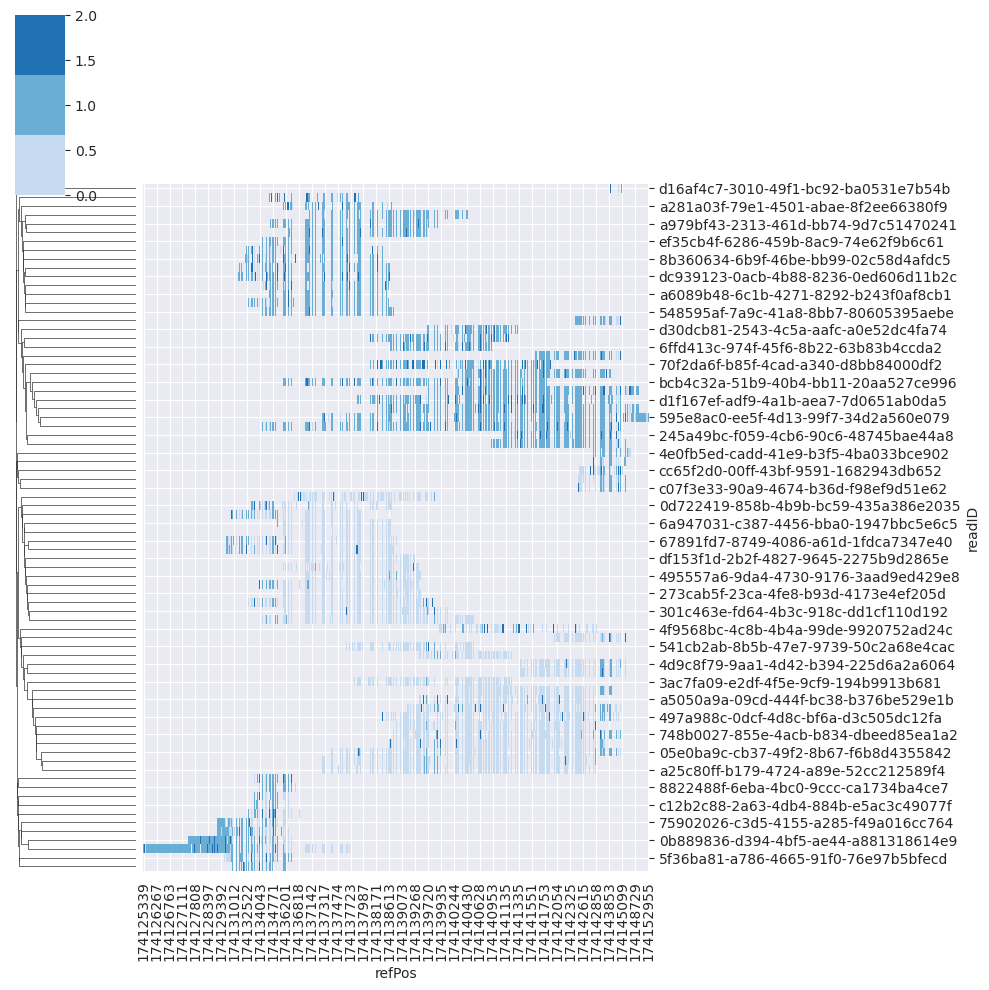

In [23]:
import seaborn as sns

sns.set_style("darkgrid")

all_dmr_df.read_matrix("Nespas-Gnasxl", 0, 0).demo_clustermap()
# all_dmr_df.read_matrix(20, 20, "Nespas-Gnasxl").demo_phased_reads_as_df()["Cluster"].value_counts()

# Gnas1A_clusters = all_dmr_df.read_matrix(40, 30, "Gnas1A").demo_phased_reads_as_df() 

In [3]:
list_of_icr_regions = list(all_dmr_df.df["Name"].unique())

In [4]:
list_of_dfs = []
for icr in list_of_icr_regions:
    try:
        print(f"Analysing {icr}")
        icr_df = all_dmr_df.read_matrix(icr).as_modDF()
    except:
        print(f"Overly strict read/CpG threshold in {icr}")
        try:
            icr_df = all_dmr_df.read_matrix(icr, 0, 0.05).as_modDF()
        except: 
            print(f"Skipping {icr}")
            pass
    try: 
        list_of_dfs.append(icr_df)
    except:
        pass

Analysing Nespas-Gnasxl
Overly strict read/CpG threshold in Nespas-Gnasxl
Analysing Gnas1A
Analysing Peg10
Analysing Mest
Analysing Peg3
Analysing Snrpn
Analysing H19
Analysing Kcnq1ot1
Analysing Rasgrf1
Analysing Zac1
Analysing Grb10
Analysing U2af1-rs1
Analysing Dlk1-Gtl2
Analysing Igf2r
Analysing Impact


In [5]:
df_imprinted_genes = pd.concat(list_of_dfs)

In [6]:
bar_df = df_imprinted_genes.replace(["c", "m", "h"], ["C", "5mC", "5hmC"])

We now have the readIDs/fragments present within each allele. Within Nespas-Gnasxl there are 39 reads with approx. 98 CpG sites. Note that this can be made larger but less effective at clustering with a lower threshold on CpGs or reads. 

## Figure

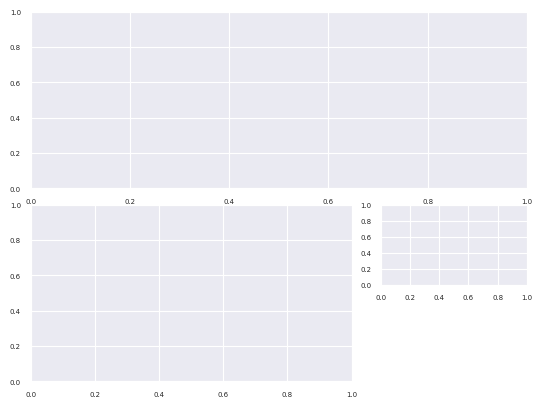

In [50]:
ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
ax2 = plt.subplot2grid((4, 3), (2, 0), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((4, 3), (2, 2))

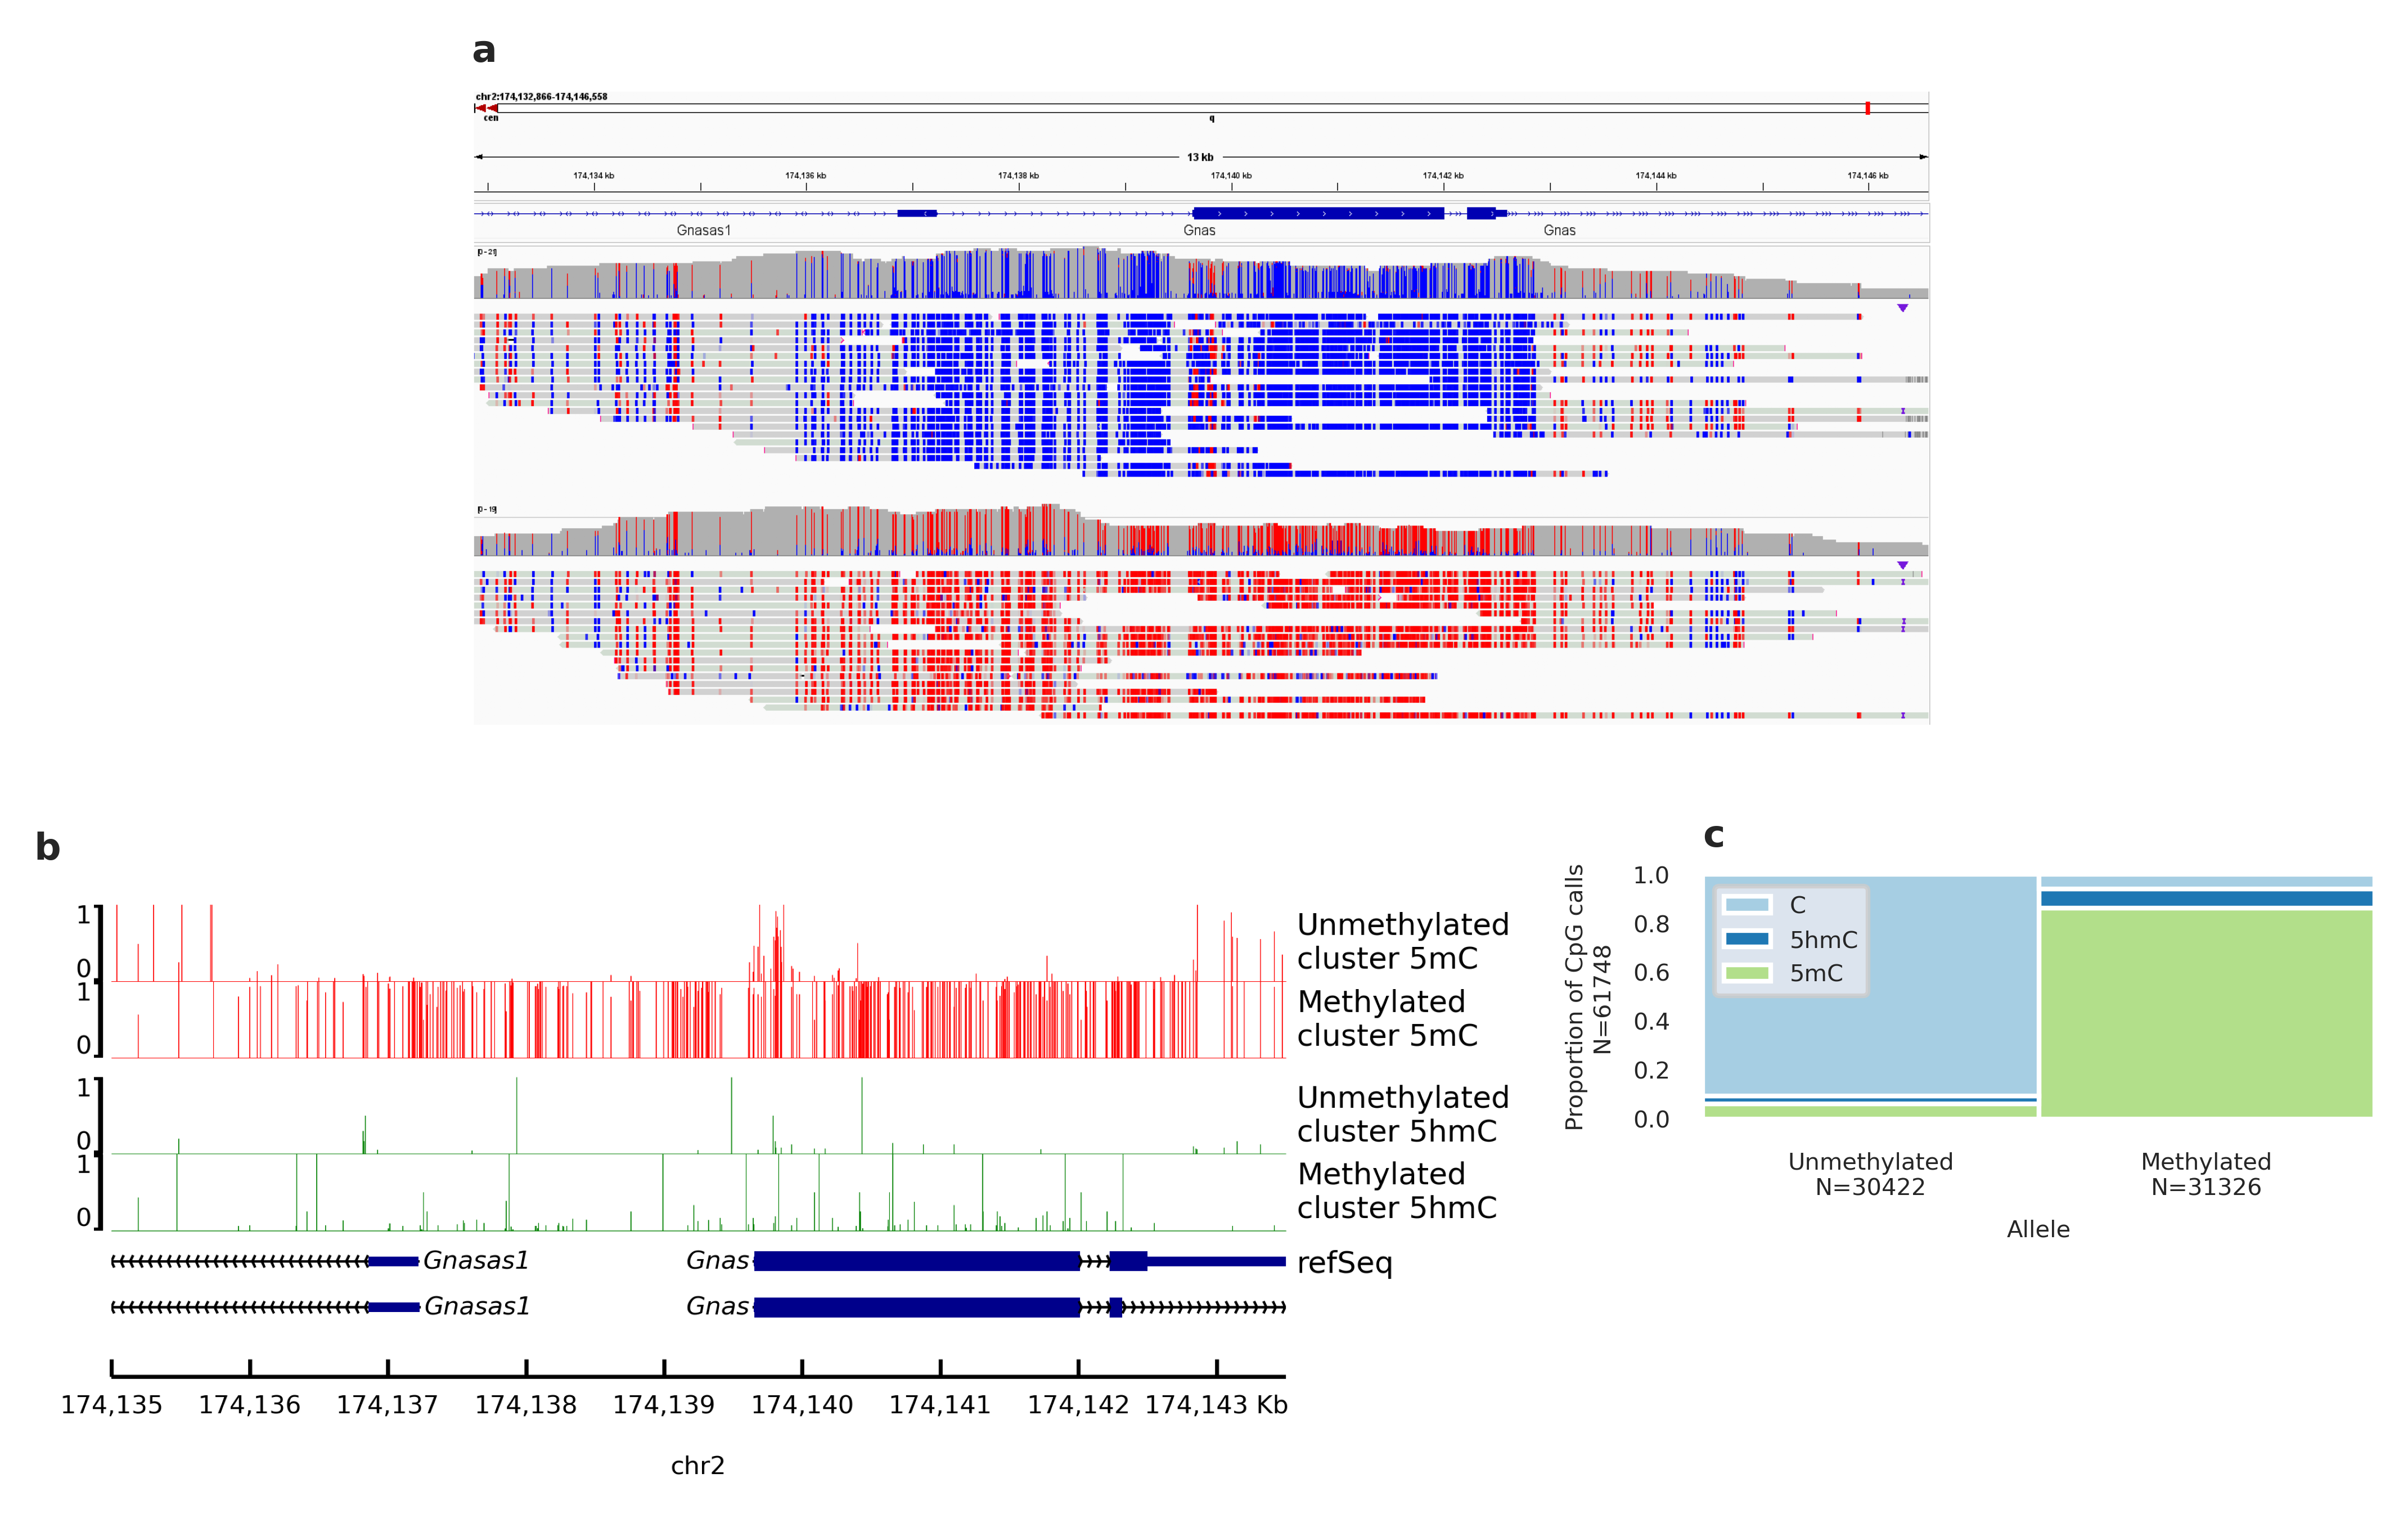

In [86]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(180/25.4, 115/25.4), dpi=600)
sns.set_style("darkgrid")
mpl.rc('font', size=5)

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
ax2 = plt.subplot2grid((4, 3), (2, 0), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((4, 3), (2, 2))

# Panel 2 # 
im1 = plt.imread("./data_tables/DMR_analysis/Nespas-Gnasx_IGV.png")
im1 = im1[:730, 230:1910, :]
ax1.imshow(im1)
ax1.tick_params(axis="both", which="both", labelbottom=False, labelleft=False)
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")
ax1.grid(None)

# Panel 2 # 
im2 = plt.imread("./data_tables/DMR_analysis/output_images/ICR_pyGenomeTracks_Img.png")
ax2.imshow(im2)
ax2.tick_params(axis="both", which="both", labelbottom=False, labelleft=False)
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")
ax2.grid(None)
# Panel 2 # 

# the alternative is two pie charts
sns.histplot(bar_df, x="Cluster", 
             hue="classification", multiple="fill", discrete=True, stat="proportion", 
             alpha=1, palette=sns.color_palette("Paired", 3),
             common_norm=True,
             hue_order=["C", "5hmC", "5mC"], ax=ax3)
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")
ax3.set_xticks(["Unmethylated", "Methylated"], [f"Unmethylated\nN={len(bar_df.loc[bar_df.loc[:, 'Cluster'] == 'Unmethylated'])}", 
                                                f"Methylated\nN={len(bar_df.loc[bar_df.loc[:, 'Cluster'] == 'Methylated'])}"])
ax3.set_xlabel("Allele")
ax3.set_ylabel(f"Proportion of CpG calls\nN={len(bar_df)}")
ax3.get_legend().set_title(None)

plt.tight_layout()
plt.gcf().set_size_inches(180/25.4, 115/25.4)
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/ICR_IP.png", dpi=600)

In [81]:

sns.color_palette("Paired", 3).as_hex()[1]

'#1f78b4'

# hMeDIP analysis

Data processing - add in new reps of IP. Currently combines the 0th and 1st replicate. 

In [1]:
import pandas as pd
import pyranges as pr
from common import *
from MultisiteTools import * 
import warnings

ip_r0_pr = pr.read_bed("./data_tables/hmedip/peak_analysis/cbm1_ip_rep0_peaks.bg")
ip_r1_pr = pr.read_bed("./data_tables/hmedip/peak_analysis/cbm1_ip_rep1_peaks.bg")

ip_r01 = ip_r0_pr.join(ip_r1_pr, strandedness=None, suffix="rep_1")
ip_r01 = ip_r01.assign("total_peakDepth", lambda pr: pr["Name"] + pr["Namerep_1"])

Feature pie chart

In [2]:
import numpy as np
annotated_peaks = featureRefPyRange("./feature_references/genic/").join(ip_r01, how="right", 
                                                                        strandedness=False, apply_strand_suffix=False, 
                                                                        report_overlap=True, suffix="_Peak").as_df()
annotated_peaks_grouped = annotated_peaks.sort_values("Overlap", ascending=False).groupby(
    ["Chromosome", "Start_Peak", "End_Peak", "total_peakDepth"]).head(1).replace(
    {"-1" : "Intergenic",
     "3UTR" : "Exon",
     "5UTR" : "Exon"})

def pieData(annotated_peak_data, 
            min_depth: int = 0, 
            max_depth: int = np.inf
            ): 
    """
    Small function that outputs labels and values for a matplotlib pie chart. Requires input DataFrame to be grouped by peak. 
    Optional min/max values filter out peaks of below minimum/above maximum depth. 
    """
    annotated_peak_data = annotated_peak_data.query(f"total_peakDepth >= {min_depth} & total_peakDepth <= {max_depth}")

    pie_labels = annotated_peak_data["feature_type"].value_counts().index
    pie_values = annotated_peak_data["feature_type"].value_counts().values

    return pie_labels, pie_values

pie_labels, pie_values = pieData(annotated_peaks_grouped, 10, 15)

Peak context histogram

In [3]:
prom_comp_data = pd.read_csv("./data_tables/prom_comp_data_10x.tsv")

# renaming columns for compatability with PyRanges
prom_comp_data = prom_comp_data.rename(columns={
    "chromosome" : "Chromosome",
    "chromStart" : "Start",
    "chromEnd" : "End"})

prom_comp_pr = CpGRange(prom_comp_data).unstrand()

with warnings.catch_warnings():
    tiles = pr.PyRanges(prom_comp_pr.group_by_tile(1000).enrichment_over_mean(include_zeros=True).df)
    
tiled_peak_df = ip_r01.join(tiles, suffix="_Tile", report_overlap=True).as_df()
tiled_peak_df = tiled_peak_df.sort_values("Overlap",ascending=False).groupby(["Chromosome", "Start", "End"]).head(1)

## Figure

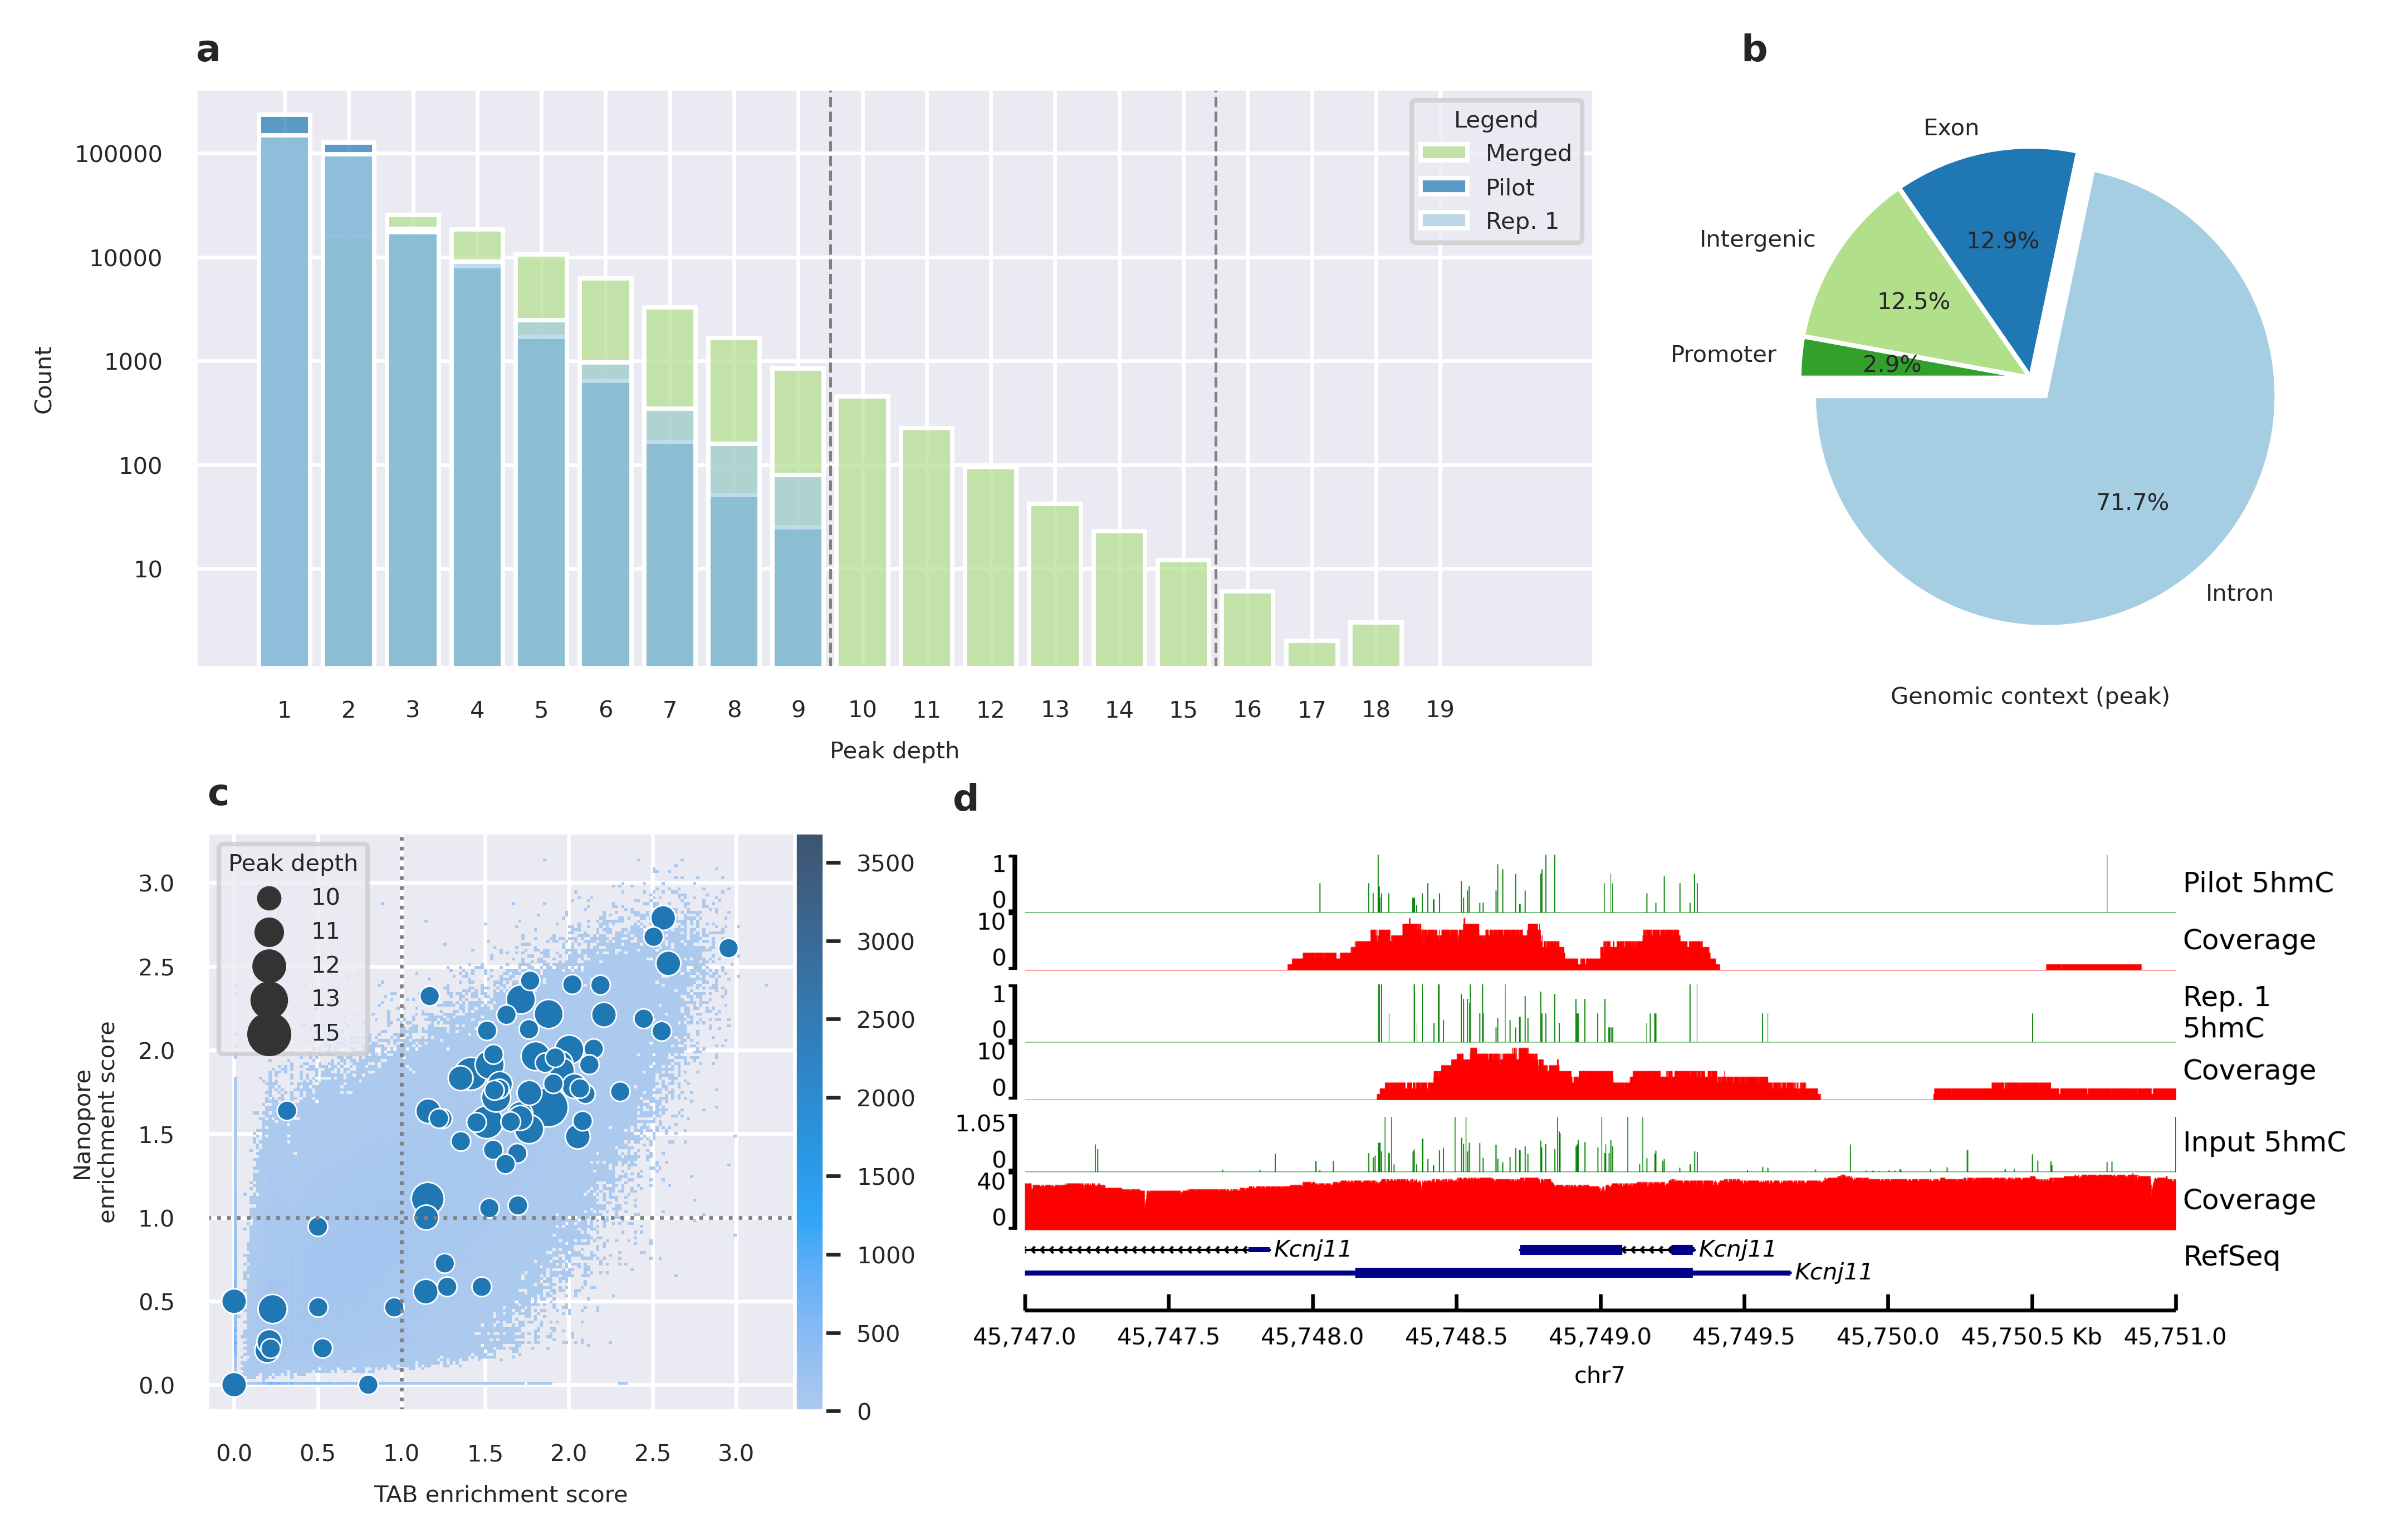

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

fig = plt.figure(figsize=(180/25.4, 115/25.4), dpi=600)
sns.set_style("darkgrid")
mpl.rc('font', size=5)

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 3), (0, 2))
ax3 = plt.subplot2grid((2, 3), (1, 0))
ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=2)

# Panel 1 # 

sns.histplot(ip_r01.as_df(), x="total_peakDepth", label="Merged", multiple="layer", color=sns.color_palette("Paired", 3)[2],
             binrange=(1, 20), discrete=True, shrink=0.8, log_scale=(False, True), element="bars", alpha=0.7, ax=ax1)
sns.histplot(ip_r0_pr.as_df(), x="Name", label="Pilot", multiple="layer", color=sns.color_palette("Paired", 3)[1],
             binrange=(1, 20), discrete=True, shrink=0.8, log_scale=(False, True), element="bars", alpha=0.7, ax=ax1)
sns.histplot(ip_r1_pr.as_df(), x="Name", label="Rep. 1", multiple="layer", color=sns.color_palette("Paired", 3)[0],
             binrange=(1, 20), discrete=True, shrink=0.8, log_scale=(False, True), element="bars", alpha=0.7, ax=ax1)

ax1.set_xticks(range(1, 20))
ax1.set_xlabel("Peak depth")
ax1.legend(title="Legend", loc="upper right")
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter("%1i"))

ax1.axvline(9.5, lw=0.6, ls="--", c="grey")
ax1.axvline(15.5, lw=0.6, ls="--", c="grey")
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

# Panel 2 # 

ax2.pie(pie_values, labels=pie_labels, startangle=180, explode=(0.1, 0, 0, 0), 
        colors=sns.color_palette("Paired", 4), autopct="%1.1f%%")
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")
ax2.set_xlabel("Genomic context (peak)")

# Panel 3 #

div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes("right", size="5%", pad=0)

sns.histplot(tiles.as_df().query("CpG_count >= 4"), x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", 
             cbar=True, cbar_ax=cax3, ax=ax3)
sns.scatterplot(tiled_peak_df.query("CpG_count >= 4 & total_peakDepth > 9 & total_peakDepth <= 15").sort_values("total_peakDepth", ascending=False), 
                x="log2enrichment_5hmC_Nanopore", y="log2enrichment_5hmC_Bisulphite", 
                size="total_peakDepth", ax=ax3)
ax3.axvline(x=1, ls=":", c="grey", lw=0.8)
ax3.axhline(y=1, ls=":", c="grey", lw=0.8)
ax3.set_aspect("equal")
ax3.legend(title="Peak depth", loc="upper left")
ax3.set_xlabel("TAB enrichment score")
ax3.set_ylabel("Nanopore\nenrichment score")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

# Panel 4 # 

im4 = plt.imread("./data_tables/hmedip/rep_image/output_img/hmedip_repImg1.png")
ax4.imshow(im4)
ax4.grid(False)
ax4.tick_params(axis="both", which="both", labelbottom=False, labelleft=False)

ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")

fig.tight_layout()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/hMeDIP.png", dpi=600)

In [98]:
bbox = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

In [104]:
bbox.width * 25.4, bbox.height * 25.4

(106.48520279595715, 43.14194444444444)

In [147]:
tiled_peak_merged = tiled_peak_df.groupby(["Chromosome", "Start_Tile", "End_Tile"], observed=True).agg(
    {"CpG_count" : "mean",
     "log2enrichment_5hmC_Nanopore" : "mean",
     "log2enrichment_5hmC_Bisulphite"  : "mean"}
).reset_index()

Is the sample enriched for 5hmC? It does *largely* align with regions that had more 5hmC in the original sample. 

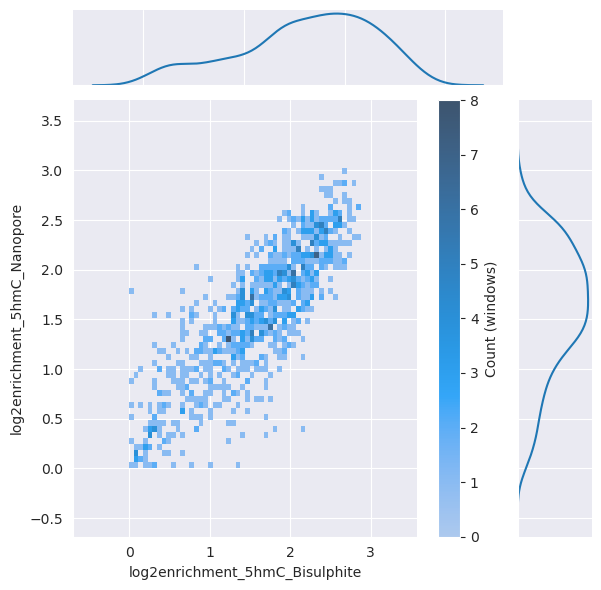

In [149]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style("darkgrid")

jg = sns.JointGrid(tiled_peak_merged, x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore")

jg.plot_joint(sns.histplot, stat="count", cbar=True, cbar_kws={"label" : "Count (windows)"}, bins=50)
jg.plot_marginals(sns.kdeplot)

jg.set_axis_labels("")


In [ ]:
import pandas as pd
from MultisiteTools import *
import warnings
import pyranges as pr

ip_modbed = readModbam2bed("/mnt/data1/doh28/data/cbm1_ip_13_07_23/cbm1_ip_13_07_23_modified_bases_mapq60.bed", min_depth=0).dropna().rename(columns={
    "chromosome" : "Chromosome",
    "chromStart" : "Start", 
    "chromEnd" : "End",
    "readCount" : "readCount_IP"
})

ip_peaks_file = pd.read_csv("../../data/cbm1_ip_13_07_23/quality_peaks.bedgraph", sep="\t", names=["Chromosome", "Start", "End", "peakDepth"]).query("peakDepth > 4")
ip_peaks_pr = pr.PyRanges(ip_peaks_file)

prom_comp_data = pd.read_csv("./data_tables/prom_comp_data_10x.tsv")

# renaming columns for compatability with PyRanges
prom_comp_data = prom_comp_data.rename(columns={
    "chromosome" : "Chromosome",
    "chromStart" : "Start",
    "chromEnd" : "End"})

prom_comp_pr = CpGRange(prom_comp_data).unstrand()

with warnings.catch_warnings():
    tiles = pr.PyRanges(prom_comp_pr.group_by_tile(1000).enrichment_over_mean(include_zeros=True).df)

tiled_peak_df = ip_peaks_pr.join(tiles, suffix="_Tile").as_df().query("CpG_count > 3")
tiled_peak_merged = tiled_peak_df.groupby(["Chromosome", "Start_Tile", "End_Tile"], observed=True).agg(
    {"CpG_count" : "mean",
     "log2enrichment_5hmC_Nanopore" : "mean",
     "log2enrichment_5hmC_Bisulphite"  : "mean"}
).reset_index()

In [ ]:
# Panel 3 # 

div3 =  make_axes_locatable(ax3)
cax3 = div3.append_axes("right", size="5%", pad=0)

sns.histplot(tiled_peak_merged, x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", 
             stat="count", cbar=True, cbar_ax=cax3, cbar_kws={"label" : "Count (peaks)"}, bins=50, ax=ax3)
ax3.set_aspect("equal")
ax3.set_xlabel("TAB enrichment score")
ax3.set_ylabel("Nanopore\nenrichment score")
ax3.set_xticks(np.arange(0, 3.5, 0.5))
ax3.set_yticks(np.arange(0, 3.5, 0.5))
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

# Panel 4 # 

ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")
